In [1]:
import numpy as np

# ============================================================
# 0) 設定（ビン化に必要な最小）
# ============================================================
NPZ_PATH = "dataset_irregular.npz"
L_GRID   = 256
SEED     = 0

np.random.seed(SEED)

# ============================================================
# 1) 読み込み（1サンプル=[cycle_id, deg, s1, label]）
# ============================================================
d = np.load(NPZ_PATH, allow_pickle=True)
train_list = d["train_list"].tolist()
test_list  = d["test_list"].tolist()

def group_by_cycle(sample_list):
    """
    sample_list を cycle_id ごとにまとめて dict にする
    dict[cid] = (deg_array, y_array, label)
    """
    arr = np.asarray(sample_list, dtype=object)
    cid = arr[:,0].astype(int)
    deg = arr[:,1].astype(float)
    y   = arr[:,2].astype(float)
    lab = arr[:,3].astype(int)

    # cycle_id -> deg の順に並べる（後の処理が安定）
    order = np.lexsort((deg, cid))
    cid, deg, y, lab = cid[order], deg[order], y[order], lab[order]

    cycles = {}
    start = 0
    while start < len(cid):
        c = int(cid[start])
        end = start
        while end < len(cid) and int(cid[end]) == c:
            end += 1
        cycles[c] = (deg[start:end], y[start:end], int(lab[start]))
        start = end
    return cycles

train_cycles = group_by_cycle(train_list)
test_cycles  = group_by_cycle(test_list)

def count_labels_from_cycles(cycles_dict):
    labs = np.array([lab for (_,_,lab) in cycles_dict.values()], dtype=int)
    u, c = np.unique(labs, return_counts=True)
    return {int(k): int(v) for k, v in zip(u, c)}

print("\n[cycle counts]")
print("train cycles total:", len(train_cycles))
print("test  cycles total:", len(test_cycles))
print("train label counts:", count_labels_from_cycles(train_cycles))
print("test  label counts:", count_labels_from_cycles(test_cycles))


[cycle counts]
train cycles total: 700
test  cycles total: 1020
train label counts: {0: 700}
test  label counts: {0: 720, 1: 60, 2: 60, 3: 60, 4: 60, 5: 60}


# 説明（bin_cycle_nan がやっていること）

## 目的
不等間隔サンプル（角度 `deg[i]` と値 `y[i]`）を、0〜360度を `L` 個に分けた「升目（ビン）」に入れて  
**1サイクル = 長さ L の配列**に変換する。  
そのビンにデータが1点も無い場合は **欠損**として `NaN` のまま残す。

出力は次の3つ。
- `x_bin[b]`：ビン `b` の平均値（欠損はNaN）
- `mask[b]`：観測あり=1 / 欠損=0
- `cnt[b]`：ビン `b` に入った生点数

---

## 1) 角度を円環として正規化する
0度と360度は同じなので、角度は円環として扱う。  
コードの
`deg % 360.0`
は数式で

$deg'_i = deg_i \bmod 360$

を意味し、必ず $deg'_i \in [0,360)$ に入る。

例：
- $deg=-10^\circ \Rightarrow deg'=350^\circ$
- $deg=370^\circ \Rightarrow deg'=10^\circ$

---

## 2) 角度 → ビン番号へ変換する
0〜360度を `L` 個に等分するので、ビン幅は

$\Delta = \dfrac{360}{L}$ [deg]

各点 $deg'_i$ が入るビン番号は

$idx_i = \left\lfloor \dfrac{deg'_i}{360}L \right\rfloor
      = \left\lfloor \dfrac{deg'_i}{\Delta} \right\rfloor$

で、$idx_i \in \{0,1,\dots,L-1\}$。

---

## 3) ビンごとの合計と点数を集計する（数式が読める形＋数値例）

### 数式（表示されやすい形）
ビン番号を `idx[i]`、値を `y[i]` とします。  
ビン `b`（0〜L-1）について

- 合計（sumv）
  
  $$
  \mathrm{sumv}[b] = \sum_{\{i \mid \mathrm{idx}[i] = b\}} y[i]
  $$

- 個数（cnt）
  
  $$
  \mathrm{cnt}[b] = \left|\{ i \mid \mathrm{idx}[i] = b \}\right|
  $$

意味：
- `idx[i]=b` の点だけを集めて、その `y[i]` を全部足したものが `sumv[b]`
- `idx[i]=b` の点が何個あるかが `cnt[b]`

---

### 数値例（手で追える）

L=8（ビン0〜7）として、次の不等間隔データをビン化します。

- deg = [10, 20, 55, 130, 131, 220, 300]
- y   = [ 1,  2,  3,   4,   6,   5,   7]

ビン幅は 360/8=45° なので、ビン番号は `idx = floor(deg/45)` です。

| i | deg[i] | y[i] | idx[i]=floor(deg/45) | 入るビン |
|---|--------|------|-----------------------|----------|
| 0 | 10     | 1    | 0                     | bin0     |
| 1 | 20     | 2    | 0                     | bin0     |
| 2 | 55     | 3    | 1                     | bin1     |
| 3 | 130    | 4    | 2                     | bin2     |
| 4 | 131    | 6    | 2                     | bin2     |
| 5 | 220    | 5    | 4                     | bin4     |
| 6 | 300    | 7    | 6                     | bin6     |

ここから `sumv[b]` と `cnt[b]` を作ります。

#### bin0（b=0）
idx[i]=0 の行は i=0,1  
- sumv[0] = y[0] + y[1] = 1 + 2 = 3  
- cnt[0]  = 2（2点）

#### bin1（b=1）
idx[i]=1 の行は i=2  
- sumv[1] = y[2] = 3  
- cnt[1]  = 1

#### bin2（b=2）
idx[i]=2 の行は i=3,4  
- sumv[2] = y[3] + y[4] = 4 + 6 = 10  
- cnt[2]  = 2

#### bin3（b=3）
idx[i]=3 の行は無い  
- sumv[3] = 0（足すものが無いので初期値のまま）  
- cnt[3]  = 0

#### bin4（b=4）
idx[i]=4 の行は i=5  
- sumv[4] = 5  
- cnt[4]  = 1

#### bin5（b=5）
無い  
- sumv[5] = 0  
- cnt[5]  = 0

#### bin6（b=6）
idx[i]=6 の行は i=6  
- sumv[6] = 7  
- cnt[6]  = 1

#### bin7（b=7）
無い  
- sumv[7] = 0  
- cnt[7]  = 0

よって最終的に

- cnt  = [2, 1, 2, 0, 1, 0, 1, 0]
- sumv = [3, 3,10, 0, 5, 0, 7, 0]

この後に平均を作ると

- x_bin[b] = sumv[b]/cnt[b]（cnt[b]>0のとき）
- 欠損（cnt[b]=0）は NaN

となります。

---

## 4) ビン平均（欠損はNaN）とマスクを作る
観測があるビンを

$mask[b] =
\begin{cases}
1 & (cnt[b] > 0)\\
0 & (cnt[b] = 0)
\end{cases}$

とし、平均値を

$x_{bin}[b] =
\begin{cases}
\dfrac{sumv[b]}{cnt[b]} & (cnt[b] > 0)\\
NaN                     & (cnt[b] = 0)
\end{cases}$

で作る。

---

# 具体的な数値例（L=8）

## 入力
$L=8$ なので $\Delta=360/8=45^\circ$。

不等間隔データ：
- `deg = [10, 20, 55, 130, 131, 220, 300]`
- `y   = [1,  2,  3,  4,   6,   5,   7 ]`

## ビン番号
$idx=\lfloor deg/45 \rfloor$ より
- 10,20 → bin0
- 55 → bin1
- 130,131 → bin2
- 220 → bin4
- 300 → bin6

よって `idx = [0,0,1,2,2,4,6]`

## 集計
- `cnt = [2,1,2,0,1,0,1,0]`
- `sumv= [3,3,10,0,5,0,7,0]`

## 出力（平均）
- `x_bin = [3/2, 3/1, 10/2, NaN, 5/1, NaN, 7/1, NaN]`
- `x_bin = [1.5, 3.0, 5.0, NaN, 5.0, NaN, 7.0, NaN]`
- `mask  = [1,1,1,0,1,0,1,0]`

この `x_bin/mask/cnt` が「ビン化した結果（補間なし）」。

In [2]:
# ============================================================
# 2) ビン化（補間なし） + 信頼度（可視化なし）
#   目的：
#     不等間隔サンプル (deg, y) を
#     「0〜360度を L_GRID 個に分けた升目（ビン）」へ入れて
#     1サイクル = 長さL_GRIDの配列 に変換する
#
#   出力（1サイクルあたり）：
#     x_bin : 各ビンの平均値（そのビンにデータが無い=欠損は NaN）
#     mask  : 観測あり=1 / 欠損=0
#     cnt   : 各ビンに入った生データ点数（何点入ったか）
#
#   さらに、ビン化の「信頼度」を数値化：
#     coverage    : 観測ありビンの割合（= maskの平均）
#     miss_rate   : 欠損ビンの割合（= 1-coverage）
#     longest_gap : 欠損(0)が連続する最大長（円環を考慮）
#     n_obs       : そのサイクルの生データ点数
# ============================================================

deg_grid = np.linspace(0, 360, L_GRID, endpoint=False).astype(float)
deg_step = float(deg_grid[1] - deg_grid[0])  # 例：L_GRID=256なら約1.40625度

def bin_cycle_nan(deg, y, L=L_GRID):
    """
    1サイクル分の不等間隔データ (deg, y) をビン化する。

    入力：
      deg : 角度配列（不等間隔、0〜360度）
      y   : 値配列（degと同じ長さ）
      L   : ビン数（=L_GRID）

    手順：
      1) deg を [0,360) に丸める（負や360以上が来ても円環として扱う）
      2) 各degをビン番号 idx に変換する
         - 0度 -> idx=0
         - 359.9度 -> idx=L-1
      3) 同じビンに複数点が入ることがあるので
         - sumv[bin] に値を足し込む
         - cnt[bin]  に点数を足し込む
      4) cnt>0 のビンだけ平均を計算して x_bin に入れる
         欠損ビンは NaN のままにする
    """
    # ---- 1) 角度を円環として [0,360) に正規化 ----
    deg = np.asarray(deg, float) % 360.0
    y   = np.asarray(y, float)

    # ---- 2) deg -> ビン番号 idx ----
    # deg/360 は [0,1) に入るので、*Lして floor すると 0..L-1
    idx = np.floor(deg / 360.0 * L).astype(int)

    # 安全のため（degが360に非常に近いなどで）範囲外をクリップ
    idx = np.clip(idx, 0, L-1)

    # ---- 3) ビンごとの合計値と点数を作る ----
    sumv = np.zeros(L, float)   # ビンごとの y 合計
    cnt  = np.zeros(L, int)     # ビンごとの 点数

    # np.add.at は「同じidxが何回出ても正しく加算」してくれる
    np.add.at(sumv, idx, y)
    np.add.at(cnt,  idx, 1)

    # ---- 4) 平均値（欠損はNaN）とマスク ----
    mask = (cnt > 0).astype(np.int8)    # 観測あり=1, 欠損=0

    x_bin = np.full(L, np.nan, float)   # まず全部NaN（欠損扱い）
    # 観測ありビンだけ平均を入れる
    x_bin[mask == 1] = sumv[mask == 1] / cnt[mask == 1]

    return x_bin, mask, cnt


def longest_gap_circular(mask):
    """
    欠損(0)が連続する最大長（円環を考慮）。

    例（L=8）：
      mask = [1,1,0,0,0,1,1,1]
      欠損連続は t=2..4 の3つ → longest_gap=3

    円環を考慮するので、
      mask = [0,0,1,1,1,1,1,0]
      末尾の0と先頭の0がつながり欠損が3連続 → longest_gap=3
    """
    m = np.asarray(mask, int)
    L = len(m)

    # 全部欠損なら最大長はL
    if m.sum() == 0:
        return int(L)

    # 欠損を1、観測を0として並べる
    z = (m == 0).astype(int)

    # 円環を見るために2回つなげる（長さ2L）
    zz = np.r_[z, z]

    # 連続する1の最大長を数える
    best = 0
    cur  = 0
    for v in zz:
        if v == 1:
            cur += 1
            if cur > best:
                best = cur
        else:
            cur = 0

    # 円環なので最大でもLに制限
    return int(min(best, L))


def build_binned_nan(cycles_dict, L=L_GRID):
    """
    cycles_dict（train_cycles/test_cycles）全体をビン化して
    (Nサイクル, L_GRID) の行列にする。

    入力：
      cycles_dict: {cycle_id: (deg_array, y_array, label)}

    出力：
      Xnan : shape (N, L)  ビン平均（欠損はNaN）
      M    : shape (N, L)  欠損マスク
      Cnt  : shape (N, L)  ビン内点数
      ylab : shape (N,)    サイクルラベル
      cids : shape (N,)    cycle_id（昇順）
      rel  : dict          信頼度配列（coverage等）
    """
    # cycle_idを昇順に固定して、配列の行と対応づける
    cids = np.array(sorted(cycles_dict.keys()), dtype=int)
    N = len(cids)

    # 出力配列を確保
    Xnan = np.full((N, L), np.nan, float)  # 値（欠損はNaN）
    M    = np.zeros((N, L), np.int8)       # mask
    Cnt  = np.zeros((N, L), int)           # count
    ylab = np.zeros(N, int)                # label

    # 信頼度（1サイクル=1値）
    coverage   = np.zeros(N, float)  # 観測ありビンの割合
    miss_rate  = np.zeros(N, float)  # 欠損割合
    longest_gp = np.zeros(N, int)    # 連続欠損最大長
    n_obs      = np.zeros(N, int)    # 生データ点数

    for i, cid in enumerate(cids):
        deg, y, lab = cycles_dict[int(cid)]

        # ---- ビン化（補間なし）----
        x_bin, mask, cnt = bin_cycle_nan(deg, y, L)

        # 行列に格納（i行目がcidのサイクル）
        Xnan[i] = x_bin
        M[i]    = mask
        Cnt[i]  = cnt
        ylab[i] = int(lab)

        # ---- 信頼度 ----
        # coverage = 観測ありビン割合（maskの平均）
        cov = float(mask.mean())
        coverage[i]  = cov
        miss_rate[i] = 1.0 - cov

        # 欠損が固まっているか（円環）
        longest_gp[i] = longest_gap_circular(mask)

        # そのサイクルの生データ点数（不等間隔点の数）
        n_obs[i] = int(len(deg))

    rel = {
        "coverage": coverage,
        "miss_rate": miss_rate,
        "longest_gap": longest_gp,
        "n_obs": n_obs,
    }
    return Xnan, M, Cnt, ylab, cids, rel


# ---- 実行：train/test をビン化（補間なし）----
Xtr_nan, Mtr, Ctr, ytr, cidtr, rel_tr = build_binned_nan(train_cycles, L_GRID)
Xte_nan, Mte, Cte, yte, cidte, rel_te = build_binned_nan(test_cycles,  L_GRID)

# ---- 簡易ログ（動作確認）----
print("\n[binned (NaN kept)]")
print("Xtr_nan:", Xtr_nan.shape, "Mtr:", Mtr.shape, "Ctr:", Ctr.shape)
print("Xte_nan:", Xte_nan.shape, "Mte:", Mte.shape, "Cte:", Cte.shape)

print("\n[reliability summary: train]")
print("coverage mean/min:", float(rel_tr["coverage"].mean()), float(rel_tr["coverage"].min()))
print("miss_rate mean/max:", float(rel_tr["miss_rate"].mean()), float(rel_tr["miss_rate"].max()))
print("longest_gap mean/max:", float(rel_tr["longest_gap"].mean()), int(rel_tr["longest_gap"].max()))
print("n_obs mean/min:", float(rel_tr["n_obs"].mean()), int(rel_tr["n_obs"].min()))


[binned (NaN kept)]
Xtr_nan: (700, 256) Mtr: (700, 256) Ctr: (700, 256)
Xte_nan: (1020, 256) Mte: (1020, 256) Cte: (1020, 256)

[reliability summary: train]
coverage mean/min: 0.9405078125 0.8984375
miss_rate mean/max: 0.0594921875 0.1015625
longest_gap mean/max: 1.0 1
n_obs mean/min: 256.0 256


C:\Users\tsenz\AppData\Local\Temp\ipykernel_16128\2500248403.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


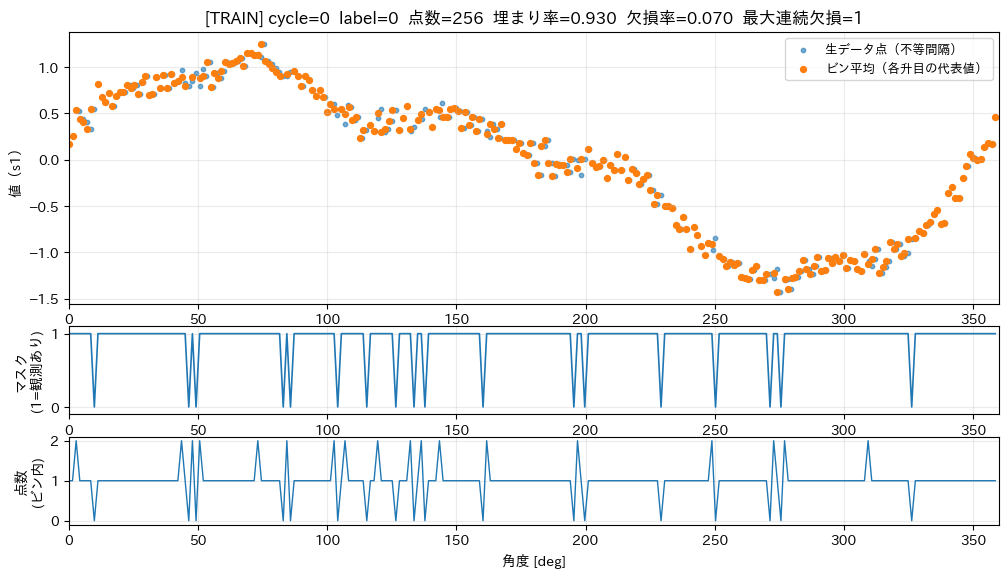

C:\Users\tsenz\AppData\Local\Temp\ipykernel_16128\2500248403.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


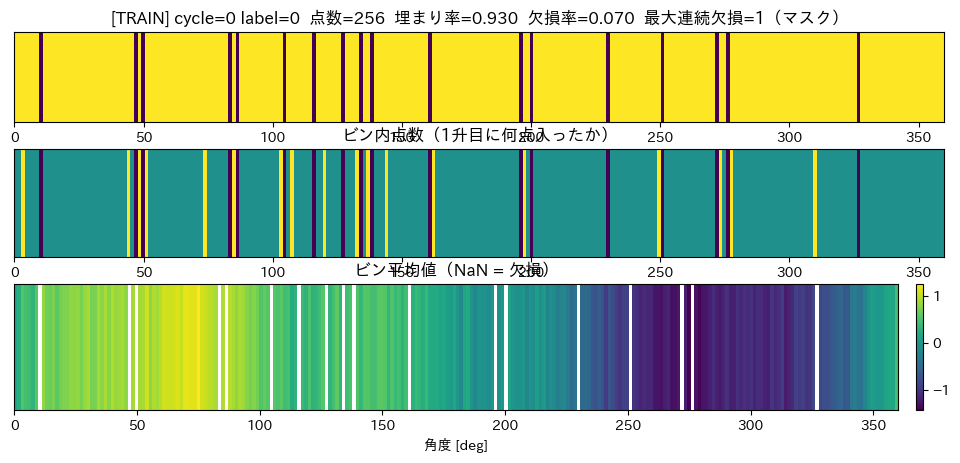

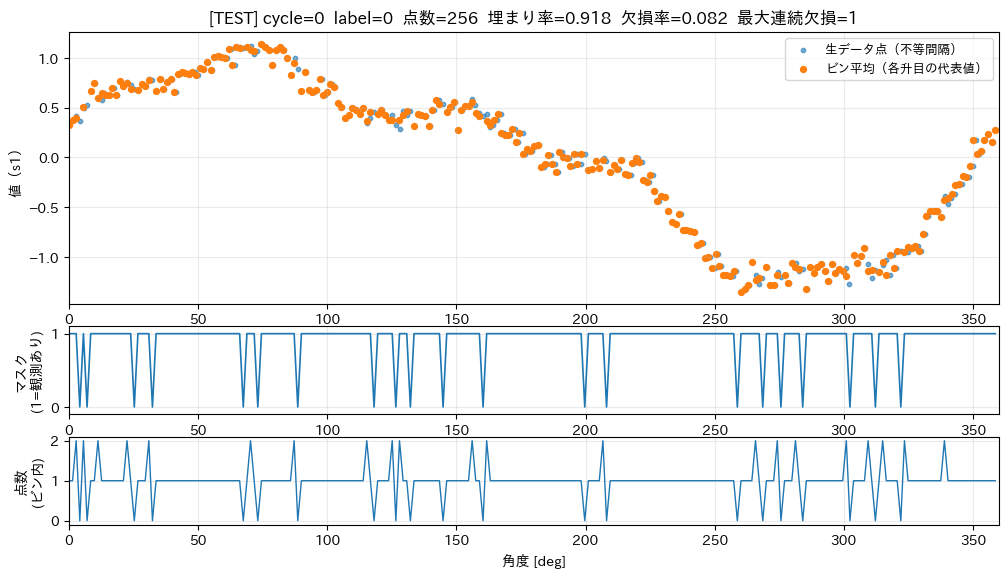

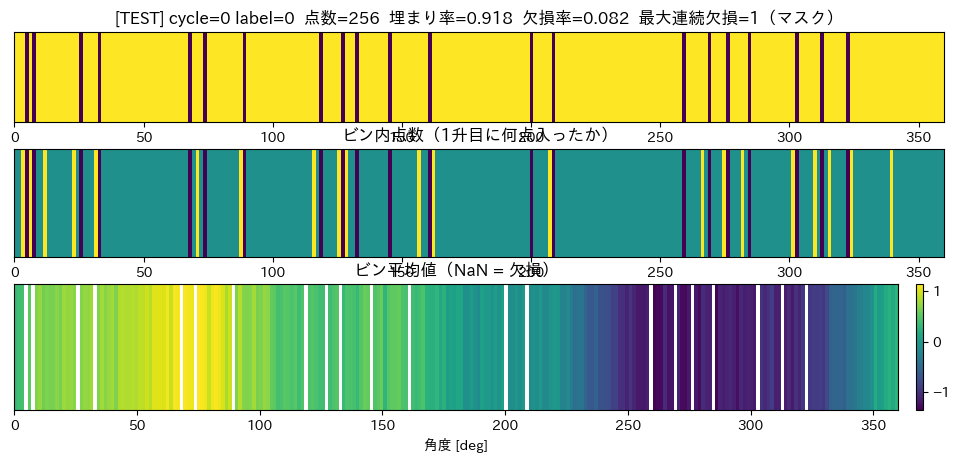

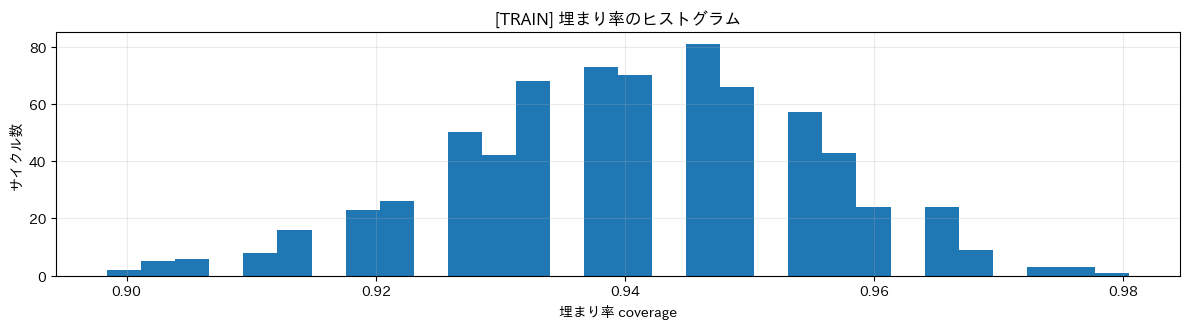

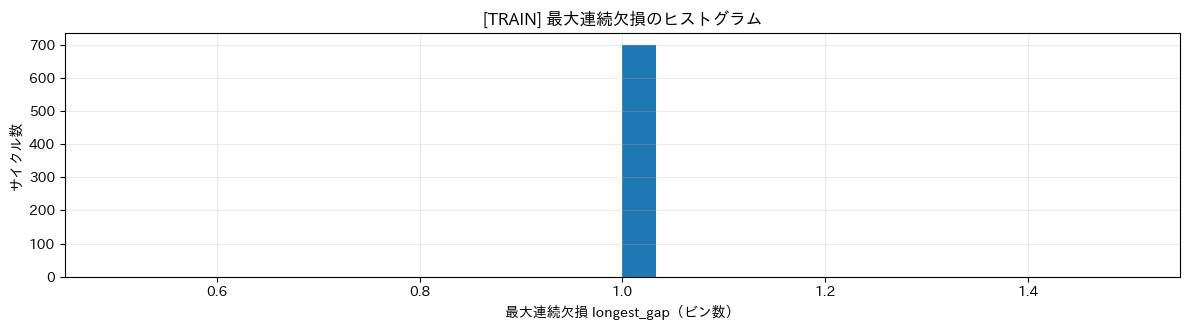

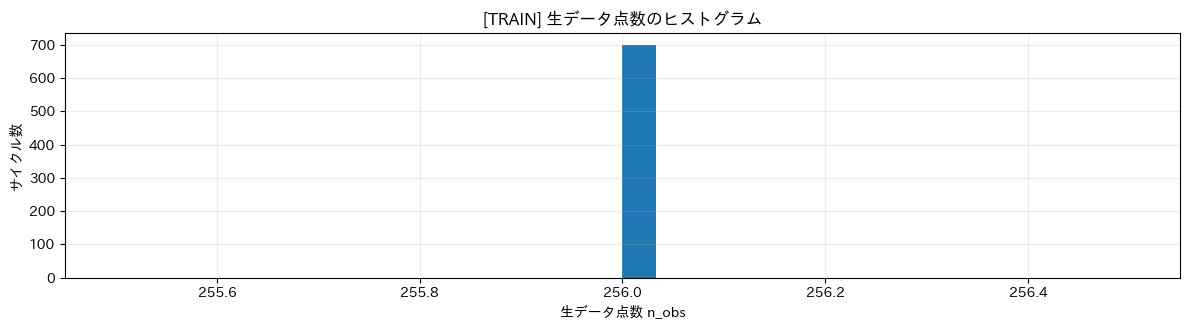

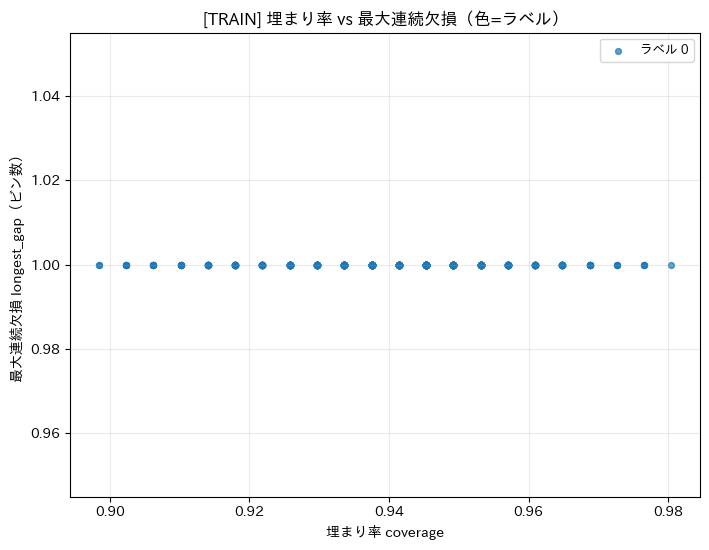

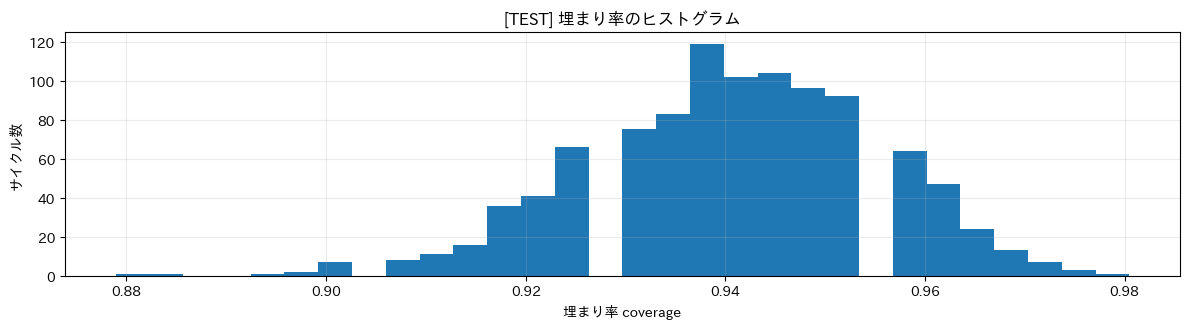

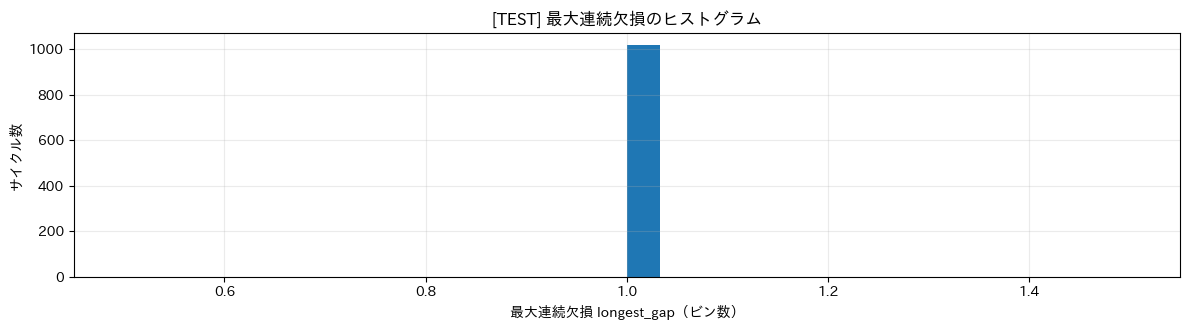

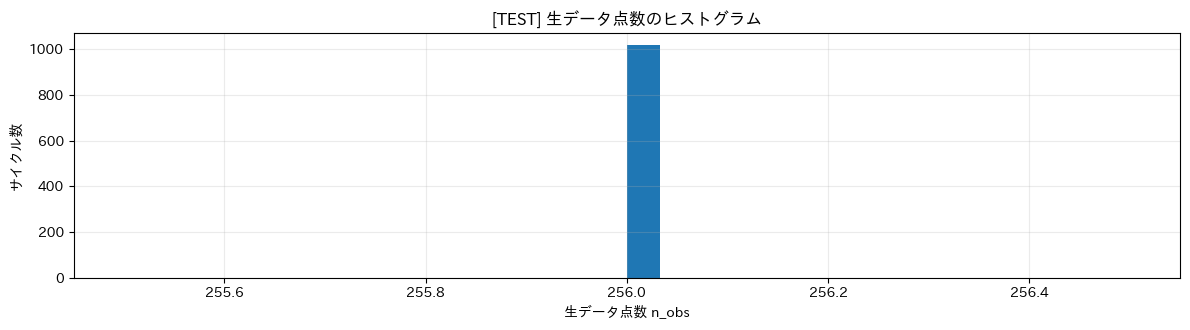

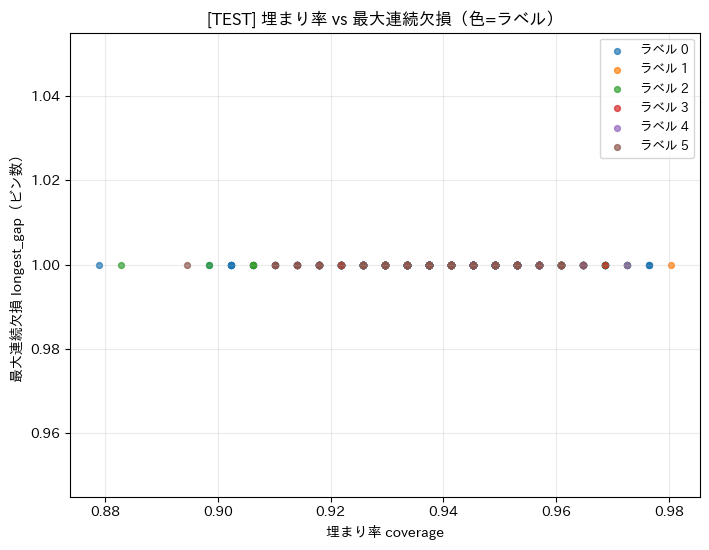

C:\Users\tsenz\AppData\Local\Temp\ipykernel_16128\2500248403.py:173: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


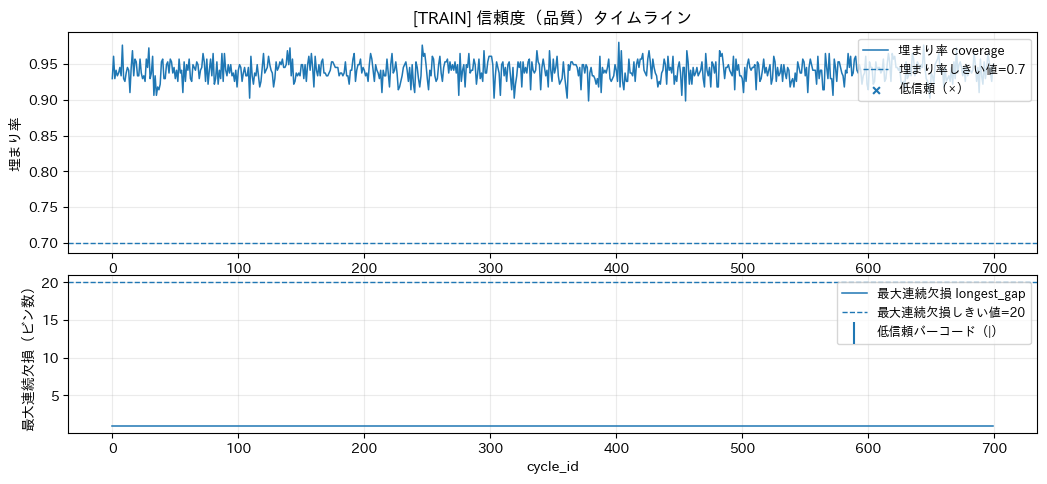

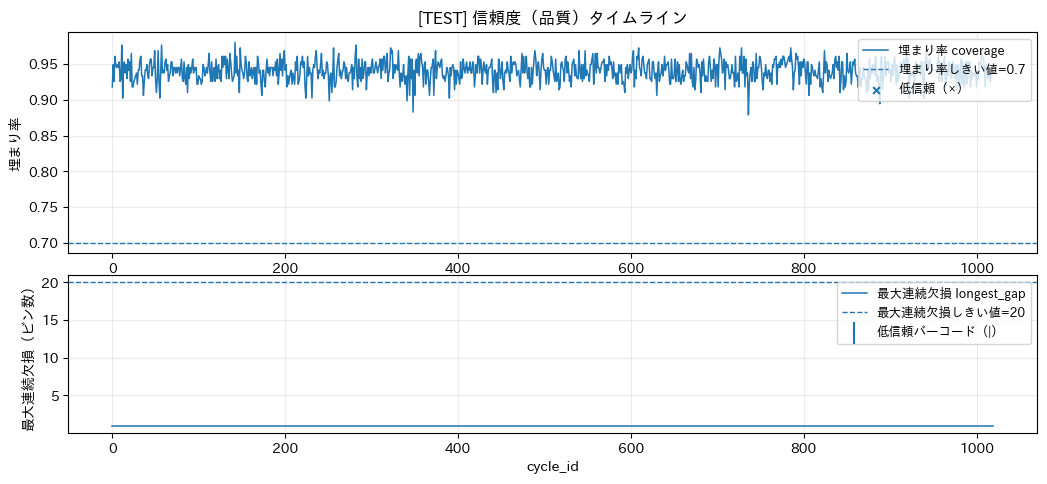

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

# ============================================================
# 可視化 1) 代表1サイクル：生データ点 vs ビン化結果（補間なし）
# ============================================================
def plot_cycle_raw_vs_binned(cycles_dict, cid, L=L_GRID, タイトル接頭=""):
    deg_raw, y_raw, lab = cycles_dict[int(cid)]
    x_bin, mask, cnt = bin_cycle_nan(deg_raw, y_raw, L)

    cov  = float(mask.mean())
    miss = 1.0 - cov
    lg   = longest_gap_circular(mask)
    n    = int(len(deg_raw))

    fig = plt.figure(figsize=(12, 6.4))
    gs = fig.add_gridspec(3, 1, height_ratios=[3.4, 1.1, 1.1], hspace=0.15)

    ax0 = fig.add_subplot(gs[0])
    ax0.scatter(deg_raw, y_raw, s=10, alpha=0.6, label="生データ点（不等間隔）")
    ax0.scatter(deg_grid[mask==1], x_bin[mask==1], s=18, label="ビン平均（各升目の代表値）")
    ax0.set_xlim(0, 360)
    ax0.set_xlabel("角度 [deg]")
    ax0.set_ylabel("値（s1）")
    ax0.set_title(f"{タイトル接頭} cycle={cid}  label={lab}  点数={n}  埋まり率={cov:.3f}  欠損率={miss:.3f}  最大連続欠損={lg}")
    ax0.grid(True, alpha=0.25)
    ax0.legend(loc="upper right", fontsize=9)

    ax1 = fig.add_subplot(gs[1], sharex=ax0)
    ax1.plot(deg_grid, mask, linewidth=1.2)
    ax1.set_ylim(-0.1, 1.1)
    ax1.set_yticks([0,1])
    ax1.set_ylabel("マスク\n(1=観測あり)")
    ax1.grid(True, alpha=0.25)

    ax2 = fig.add_subplot(gs[2], sharex=ax0)
    ax2.plot(deg_grid, cnt, linewidth=1.0)
    ax2.set_ylabel("点数\n(ビン内)")
    ax2.set_xlabel("角度 [deg]")
    ax2.grid(True, alpha=0.25)

    plt.tight_layout()
    plt.show()


# ============================================================
# 可視化 2) 代表1サイクル：升目（ビン）表示（1行ヒートマップ）
# ============================================================
def plot_cycle_bins_as_tiles(cycles_dict, cid, L=L_GRID, タイトル接頭=""):
    deg_raw, y_raw, lab = cycles_dict[int(cid)]
    x_bin, mask, cnt = bin_cycle_nan(deg_raw, y_raw, L)

    cov  = float(mask.mean())
    miss = 1.0 - cov
    lg   = longest_gap_circular(mask)
    n    = int(len(deg_raw))

    M = mask.reshape(1, -1)
    C = cnt.reshape(1, -1)
    X = x_bin.reshape(1, -1)

    fig = plt.figure(figsize=(12, 4.9))
    gs = fig.add_gridspec(3, 1, height_ratios=[1.0, 1.2, 1.4], hspace=0.25)

    ax0 = fig.add_subplot(gs[0])
    ax0.imshow(M, aspect="auto", origin="lower", extent=[0,360,0,1])
    ax0.set_yticks([])
    ax0.set_xlabel("角度 [deg]")
    ax0.set_title(f"{タイトル接頭} cycle={cid} label={lab}  点数={n}  埋まり率={cov:.3f}  欠損率={miss:.3f}  最大連続欠損={lg}（マスク）")

    ax1 = fig.add_subplot(gs[1])
    ax1.imshow(C, aspect="auto", origin="lower", extent=[0,360,0,1])
    ax1.set_yticks([])
    ax1.set_xlabel("角度 [deg]")
    ax1.set_title("ビン内点数（1升目に何点入ったか）")

    ax2 = fig.add_subplot(gs[2])
    im = ax2.imshow(X, aspect="auto", origin="lower", extent=[0,360,0,1])
    ax2.set_yticks([])
    ax2.set_xlabel("角度 [deg]")
    ax2.set_title("ビン平均値（NaN = 欠損）")
    plt.colorbar(im, ax=ax2, fraction=0.03, pad=0.02)

    plt.tight_layout()
    plt.show()


# ============================================================
# 可視化 3) 信頼度（埋まり率・最大連続欠損・点数）の分布
# ============================================================
def plot_reliability_summary(ylab, rel, タイトル接頭=""):
    cov = np.asarray(rel["coverage"], float)
    lg  = np.asarray(rel["longest_gap"], int)
    n   = np.asarray(rel["n_obs"], int)

    plt.figure(figsize=(12,3.4))
    plt.hist(cov, bins=30)
    plt.xlabel("埋まり率 coverage")
    plt.ylabel("サイクル数")
    plt.title(f"{タイトル接頭} 埋まり率のヒストグラム")
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,3.4))
    plt.hist(lg, bins=30)
    plt.xlabel("最大連続欠損 longest_gap（ビン数）")
    plt.ylabel("サイクル数")
    plt.title(f"{タイトル接頭} 最大連続欠損のヒストグラム")
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,3.4))
    plt.hist(n, bins=30)
    plt.xlabel("生データ点数 n_obs")
    plt.ylabel("サイクル数")
    plt.title(f"{タイトル接頭} 生データ点数のヒストグラム")
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7.2,5.6))
    for k in np.unique(ylab):
        m = (ylab == k)
        plt.scatter(cov[m], lg[m], s=18, alpha=0.7, label=f"ラベル {int(k)}")
    plt.xlabel("埋まり率 coverage")
    plt.ylabel("最大連続欠損 longest_gap（ビン数）")
    plt.title(f"{タイトル接頭} 埋まり率 vs 最大連続欠損（色=ラベル）")
    plt.grid(True, alpha=0.25)
    plt.legend(loc="best", fontsize=9)
    plt.tight_layout()
    plt.show()


# ============================================================
# 可視化 4) 信頼度をサイクル順に表示（バーコード付き）
# ============================================================
def plot_reliability_timeline(cids, ylab, rel, タイトル接頭="", cov_min=0.70, gap_max=20):
    cids = np.asarray(cids, int)
    cov = np.asarray(rel["coverage"], float)
    lg  = np.asarray(rel["longest_gap"], int)

    order = np.argsort(cids)
    cids, cov, lg = cids[order], cov[order], lg[order]

    低信頼 = (cov < cov_min) | (lg > gap_max)

    fig = plt.figure(figsize=(12.5,5.2))
    gs = fig.add_gridspec(2, 1, height_ratios=[1.4, 1.0], hspace=0.12)

    ax0 = fig.add_subplot(gs[0])
    ax0.plot(cids, cov, linewidth=1.1, label="埋まり率 coverage")
    ax0.axhline(cov_min, linestyle="--", linewidth=1.0, label=f"埋まり率しきい値={cov_min}")
    ax0.scatter(cids[低信頼], cov[低信頼], marker="x", s=24, label="低信頼（×）")
    ax0.set_ylabel("埋まり率")
    ax0.set_title(f"{タイトル接頭} 信頼度（品質）タイムライン")
    ax0.grid(True, alpha=0.25)
    ax0.legend(loc="upper right", fontsize=9)

    ax1 = fig.add_subplot(gs[1], sharex=ax0)
    ax1.plot(cids, lg, linewidth=1.1, label="最大連続欠損 longest_gap")
    ax1.axhline(gap_max, linestyle="--", linewidth=1.0, label=f"最大連続欠損しきい値={gap_max}")
    ymin, ymax = ax1.get_ylim()
    ax1.scatter(cids[低信頼], np.full(低信頼.sum(), ymin + 0.02*(ymax-ymin)),
                marker="|", s=250, label="低信頼バーコード（|）")
    ax1.set_xlabel("cycle_id")
    ax1.set_ylabel("最大連続欠損（ビン数）")
    ax1.grid(True, alpha=0.25)
    ax1.legend(loc="upper right", fontsize=9)

    plt.tight_layout()
    plt.show()


# ============================================================
# 実行例
# ============================================================
train_normal_cids = [cid for cid,(deg,y,lab) in train_cycles.items() if lab == 0]
if len(train_normal_cids) > 0:
    cid0 = train_normal_cids[0]
    plot_cycle_raw_vs_binned(train_cycles, cid0, L_GRID, タイトル接頭="[TRAIN]")
    plot_cycle_bins_as_tiles(train_cycles, cid0, L_GRID, タイトル接頭="[TRAIN]")

cid1 = list(test_cycles.keys())[0]
plot_cycle_raw_vs_binned(test_cycles, cid1, L_GRID, タイトル接頭="[TEST]")
plot_cycle_bins_as_tiles(test_cycles, cid1, L_GRID, タイトル接頭="[TEST]")

plot_reliability_summary(ytr, rel_tr, タイトル接頭="[TRAIN]")
plot_reliability_summary(yte, rel_te, タイトル接頭="[TEST]")

plot_reliability_timeline(cidtr, ytr, rel_tr, タイトル接頭="[TRAIN]", cov_min=0.70, gap_max=20)
plot_reliability_timeline(cidte, yte, rel_te, タイトル接頭="[TEST]",  cov_min=0.70, gap_max=20)

# 特徴量の算出

記号の約束（表内で使う）
L は 1サイクルのビン数。m[i] は観測あり=1、欠損=0 のマスク。
観測インデックス集合を $O=\{\,i\in\{0,\dots,L-1\}\mid m[i]=1\,\}$ とする。
「Oの個数（観測点数）」は $n_{\mathrm{obs}}=\sum_{i=0}^{L-1} m[i]$ と書く（表内ではこの形で書く）。

| 区分 | 特徴量名 | MSPC(PCA)に入れる？ | 計算法（簡易式） | 理由（短く） | 備考（使い方） |
|---|---|---:|---|---|---|
| 信頼度 | coverage | いいえ | $$\mathrm{coverage}=\frac{1}{L}\sum_{i=0}^{L-1} m[i]$$ | 判定の“信頼度”。混ぜると近道学習になりやすい | ゲート：coverageが低いサイクルは「判定保留/別扱い」 |
| 信頼度 | miss_rate | いいえ | $$\mathrm{miss\_rate}=1-\mathrm{coverage}$$ | coverageと同じ情報（冗長） | 使うならcoverageの代わり。両方は不要 |
| 信頼度 | longest_gap | いいえ | $$\mathrm{longest\_gap}=\max(\text{連続欠損長})$$ | 欠損の連続具合＝信頼度。小さいほど信頼度が高い。混ぜると欠損＝異常になりやすい | ゲート：longest_gapが大きいサイクルは「判定保留/位相スコア無効」 |
| 信頼度 | n_obs | いいえ | $$n_{\mathrm{obs}}=\sum_{i=0}^{L-1} m[i]$$ | 点数の多寡は品質指標。混ぜると誤学習の原因 | ゲート：n_obsが小さいサイクルは「低信頼」 |
| 異常（上下） | offset_abs（推奨） | はい | $$\mathrm{offset}=\mathrm{mean}(x_{al}-x_{ref})$$ $$\mathrm{offset\_abs}=\mathrm{abs}(\mathrm{offset})$$ | 上下シフトの強さを1本で表す主特徴 | offset_meanは符号付き。MSPCならabs推奨 |
| 異常（上下） | offset_mean（任意） | いいえ（基本） | $$\mathrm{offset\_mean}=\mathrm{offset}$$ | 符号は説明に便利だが、入力として冗長になりやすい | 保存はする（説明用） |
| 異常（横ずれ） | phase_shift_deg | はい | $$s^{*}=\arg\max_s \mathrm{corr}(x_{ref},\mathrm{roll}(x,s))$$ $$\mathrm{phase\_shift\_deg}=\frac{360}{L}\,s^{*}$$（必要なら $[-180,180]$ へ折返し） | 横ずれ量そのもの | 円環なので0/360近傍に注意（折返し推奨） |
| 異常（横ずれ信頼度） | phase_corr_max | はい（またはゲート） | $$\mathrm{phase\_corr\_max}=\max_s \mathrm{corr}(x_{ref},\mathrm{roll}(x,s))$$（マスク交差で計算） | 位相推定が怪しい時に下がる。MSPCが“位相不明”も拾える | 重要度高。低相関なら位相量を信用しないゲートでも可 |
| 異常（周波数：全体） | cwt_hl（推奨） | はい | CWT係数 $W(s,t)$ から $$Z(s,t)=\log(\mathrm{abs}(W(s,t))^2+\varepsilon)$$ $$E(s)=\mathrm{mean}_t Z(s,t)$$ $$\mathrm{cwt\_hl}=\mathrm{mean}_{s\in High}E(s)-\mathrm{mean}_{s\in Low}E(s)$$ | 高周波/低周波の相対増加を1本で表す | CWT前だけNaNを補間（円環線形など） |
| 異常（周波数：全体） | cwt_low / cwt_high（任意） | 条件付き（必要なら） | $$\mathrm{cwt\_low}=\mathrm{mean}_{s\in Low}E(s)$$ $$\mathrm{cwt\_high}=\mathrm{mean}_{s\in High}E(s)$$ | どちら側が変わったか分解できる | 次元増。必要時のみ |
| 異常（形状） | shape_rms（推奨） | はい | 整列後 $x_{al}=\mathrm{roll}(x,-s^{*})$、オフセット除去 $x_{corr}=x_{al}-\mathrm{offset}$、残差 $r=x_{corr}-x_{ref}$ として $$\mathrm{shape\_rms}=\sqrt{\mathrm{mean}(r^2)}$$（マスク交差） | 整列＋上下補正後の“全体ズレ” | スパイクに引っ張られるならトリムRMS等 |
| 異常（形状） | shape_1minus_corr（推奨） | はい | $$\mathrm{shape\_1minus\_corr}=1-\mathrm{corr}(x_{corr},x_{ref})$$（マスク交差） | “似てなさ”を相関で表現（RMSと補完） | どちらか1本にするならRMSでも可 |
| 異常（スパイク強さ） | spike_max（推奨） | はい | $$\mathrm{spike\_max}=\max_{i\in O}\mathrm{abs}(r_i)$$（マスク交差なら \(O\) を交差集合に置換） | 局所尖りの強さ | 単発ノイズにも反応→spike_countとセットが強い |
| 異常（スパイク数） | spike_count（推奨） | はい | 観測集合 $O=\{i\mid m[i]=1\}$、$\tilde r=\mathrm{median}_{i\in O}(r_i)$、$$\mathrm{MAD}=\mathrm{median}_{i\in O}\bigl(\mathrm{abs}(r_i-\tilde r)\bigr)$$ $$\sigma_{rob}=1.4826\,\mathrm{MAD},\quad \tau=k\sigma_{rob}$$ $$\mathrm{spike\_count}=\sum_{i\in O}\mathbf{1}\left(\mathrm{abs}(r_i-\tilde r)>\tau\right)$$ | しきい値を超える尖りが「何点」あるか | $k$は例：6。calib正常で分位点が妥当になるよう調整可 |
| 異常（スパイク割合） | spike_rate（任意） | 条件付き | 上と同じ定義で $$\mathrm{spike\_rate}=\frac{1}{n_{\mathrm{obs}}}\sum_{i\in O}\mathbf{1}\left(\mathrm{abs}(r_i-\tilde r)>\tau\right)$$ ただし $$n_{\mathrm{obs}}=\sum_{i=0}^{L-1} m[i]$$ | 欠損が多いサイクルでも比較しやすい「割合」 | 欠損が揺れるなら有効。入れるならcountとどちらか |
### 推奨セット（MSPC入力に入れる最小構成）
- offset_abs
- phase_shift_deg
- phase_corr_max
- cwt_hl
- shape_rms
- spike_max
- spike_count

### 推奨セット（MSPCに入れない＝ゲート/ログ用）
- coverage
- longest_gap
- n_obs
（miss_rateはcoverageの代替なので通常不要）

In [4]:
import numpy as np
import pywt

# ============================================================
# 3) 特徴量算出（関数分割）→ 最終的にデータ行列を作る（改良版）
#
# このセルの目的：
#   1) 1サイクル（ビン化済み x_nan, mask）から
#      MSPC入力用の特徴量を計算する
#   2) 全サイクル分をまとめて「特徴量行列」を作る
#
# 前提（このセルの前で用意しておくもの）：
#   - Xtr_nan, Mtr, ytr, cidtr, rel_tr   （train: ビン平均NaN保持/マスク/ラベル/cycle_id/信頼度）
#   - Xte_nan, Mte, yte, cidte, rel_te   （test:  同上）
#   - L_GRID, deg_grid
#   - WAVELET, N_SCALES（CWT用）
#
# MSPCに入れる最小構成（あなたの指定）：
#   offset_abs, phase_shift_deg, phase_corr_max,
#   cwt_hl, shape_rms, spike_max, spike_count
#
# MSPCに入れない（ゲート/ログ）：
#   coverage, longest_gap, n_obs
# ============================================================


# ============================================================
# 3-0) 代表テンプレ波形の作り方（改良点）
#
# ここでは「train からランダムに N本選んでテンプレを作る」
#   - ラベルは一切使わない（指定どおり）
#   - 欠損(NaN)は bin ごとに無視して平均（nanmean）
#
# 注意：
#   ラベルを無視すると「異常も混ざったテンプレ」になりうる。
#   その場合、検知感度が下がる（基準が汚れる）ことがある。
#   ただし今回は“指定どおり”に実装する。
# ============================================================
def build_template_random_from_train(X_nan_2d, cids=None, n_select=50, seed=0, min_bins=32):
    """
    X_nan_2d : (N, L) 1サイクル=1行、欠損はNaN
    cids     : (N,)   cycle_id（あればテンプレに使ったcycleを返す用）
    n_select : テンプレ作成に使うサイクル数（任意）
    seed     : 乱数固定
    min_bins : テンプレ候補として最低限必要な「観測ビン数」
               欠損だらけのサイクルをテンプレに混ぜるのを避けるため
    returns:
      x_ref       : (L,) テンプレ波形（NaNはなるべく減る）
      ref_mask    : (L,) 1=テンプレが定義できたビン（NaNでない）
      used_index  : (K,) 選ばれた行index（K<=n_select）
      used_cids   : (K,) 選ばれたcycle_id（cidsがある場合）
    """
    rng = np.random.default_rng(int(seed))
    X = np.asarray(X_nan_2d, float)
    N, L = X.shape

    # --- テンプレ候補を「観測ビン数 >= min_bins」の行に限定 ---
    obs_bins = np.isfinite(X).sum(axis=1)
    cand = np.where(obs_bins >= int(min_bins))[0]
    if len(cand) == 0:
        raise ValueError("テンプレ候補がありません（min_binsが厳しすぎる可能性）。")

    rng.shuffle(cand)
    K = int(min(int(n_select), len(cand)))
    used_index = cand[:K]

    # --- nanmeanでビンごとに平均（NaNは無視） ---
    x_ref = np.nanmean(X[used_index], axis=0).astype(float)  # (L,)
    ref_mask = np.isfinite(x_ref).astype(np.int8)            # (L,)

    if int(ref_mask.sum()) == 0:
        raise ValueError("テンプレが全ビンNaNになりました（候補が悪い/欠損が多い）。")

    used_cids = None
    if cids is not None:
        used_cids = np.asarray(cids, int)[used_index]

    return x_ref, ref_mask, used_index, used_cids



In [5]:

# ============================================================
# 3-1) CWT直前だけ使う：円環線形補間
#
# なぜ必要？
#   pywt.cwt は NaN を含む配列をそのまま扱えないため。
#   ただし「補間はCWT用の入力を作るときだけ」行い、
#   offset/phase/shape/spike の計算は補間せず（mask付き）で行う。
# ============================================================
def circular_linear_fill_from_mask(x_nan, mask):
    """
    x_nan : (L,) 欠損はNaN
    mask  : (L,) 観測あり=1/欠損=0（NaNも欠損扱いに寄せる）
    return: (L,) 欠損を円環線形補間で埋めた配列（CWT用）
    """
    x = np.asarray(x_nan, float)
    m = np.asarray(mask, int)
    L = len(x)

    # 有効点：mask=1 かつ NaNでない
    ok = (m == 1) & np.isfinite(x)
    n_ok = int(ok.sum())

    if n_ok == 0:
        # 全欠損 → 0埋め（本来は信頼度ゲートで弾く想定）
        return np.zeros(L, float)
    if n_ok == 1:
        # 1点だけ → 全部その値（本来はゲート推奨）
        v = float(x[ok][0])
        return np.full(L, v, float)

    idx = np.where(ok)[0]
    val = x[idx].astype(float)

    # 円環補間：最初の点を +L して末尾に追加（0度と360度がつながる）
    idx_ext = np.r_[idx, idx[0] + L]
    val_ext = np.r_[val, val[0]]

    # 0..L-1 を埋める
    return np.interp(np.arange(L), idx_ext, val_ext)



## circular_linear_fill_from_mask の処理（具体例つき）

### この関数がやりたいこと
入力は「ビン化した1サイクル」の配列です。

- `x_nan[b]`：ビン b の値（データが無いビンは NaN）
- `mask[b]`：ビン b に観測があるか（1=ある, 0=ない）
- ビンは円環（0度と360度がつながる）として扱う

この関数は、欠損（NaN）を **円環として線形補間**して、CWTに入れられる「欠損なし配列」を作ります。

---

### 1) 有効点 ok を作る
有効点の条件は2つ：
- mask[b] = 1（観測あり）
- x_nan[b] が NaN ではない（数値が入っている）

これを満たすビンの集合を
- `ok = True の場所`
とします。

---

### 2) 有効点の数 n_ok によって場合分け
- n_ok = 0（有効点が0個）  
  → 何も補間できないので、全部0で埋めて返す（本来はゲートで弾く想定）

- n_ok = 1（有効点が1個）  
  → 1点しかないので、全ビンをその値で埋める（これも本来はゲート推奨）

- n_ok ≥ 2  
  → ふつうの補間を行う

ここからがメインです。

---

### 3) n_ok ≥ 2 のとき：補間用の点列（idx, val）を作る
- `idx`：有効点のビン番号の配列（昇順）
- `val`：そのビンの値（x_nanの対応値）

例として、L=8（ビン0〜7）で考えます。

#### 例データ（欠損あり）
- L = 8
- x_nan = [NaN, 10, NaN, NaN, 20, NaN, NaN, 40]
- mask  = [  0,  1,   0,   0,  1,   0,   0,  1]

有効点はビン 1, 4, 7 なので
- idx = [1, 4, 7]
- val = [10, 20, 40]

---

### 4) “円環”補間のために、最初の点を末尾にもう一回足す
ここがこの関数のキモです。

0度と360度がつながるので、ビン7の次はビン0に戻ります。  
その「戻り区間」を線形補間したい。

そこで、
- 最初の点（idx[0], val[0]）＝(1, 10)
を
- (idx[0] + L, val[0])＝(1+8, 10)＝(9, 10)
として末尾に追加します。

つまり

- idx_ext = [1, 4, 7, 9]
- val_ext = [10, 20, 40, 10]

こうすると、補間は区間
- 1→4
- 4→7
- 7→9（これが「円環の戻り部分」を表す）
の3つで行えるようになります。

---

### 5) 0..L-1 の全ビンを補間で埋める（線形）
補間は「隣接する2点の間を直線でつなぐ」です。

今の例で、区間ごとに埋める値を具体的に計算します。

#### 区間 1→4（値 10→20）
傾きは
- (20−10)/(4−1) = 10/3 ≈ 3.333

なので
- ビン1：10
- ビン2：10 + 1*(10/3) = 13.333...
- ビン3：10 + 2*(10/3) = 16.666...
- ビン4：20

#### 区間 4→7（値 20→40）
傾きは
- (40−20)/(7−4) = 20/3 ≈ 6.666

なので
- ビン4：20
- ビン5：20 + 1*(20/3) = 26.666...
- ビン6：20 + 2*(20/3) = 33.333...
- ビン7：40

#### 区間 7→9（値 40→10）※円環部分
傾きは
- (10−40)/(9−7) = -30/2 = -15

なので
- ビン7：40
- ビン8：25（ただしビン8は存在しない。これは“360度の先”）
- ビン9：10

ここで欲しいのはビン0の値です。  
ビン0は「円環上ではビン8相当」なので、25が入ります。

結果（0..7に丸めた補間結果）
- ビン0：25
- ビン1：10
- ビン2：13.333...
- ビン3：16.666...
- ビン4：20
- ビン5：26.666...
- ビン6：33.333...
- ビン7：40

つまり返り値は
- filled = [25, 10, 13.33, 16.67, 20, 26.67, 33.33, 40]

これが「欠損を埋めた円環線形補間」の出力です。

---

### なぜ idx[0] + L を足すだけで円環になるのか
ビン番号を 0..L-1 だけで補間すると、最後の有効点（例では7）から最初の有効点（例では1）へ戻る区間が表現できません。

(7,40) の次が (1,10) ではなく、円環としては
(7,40) → (9,10) と考えることで  
「7→8→9」の区間ができ、そこにビン0（=8相当）の値も自然に入ります。

---

### まとめ（この関数の出力が意味するもの）
- 欠損があっても CWT に入れられる “欠損なし波形” を作る
- 補間は「直線」で、しかも「0度と360度をつなげた円環」として補間する
- 欠損が固まっていると補間部分が増えるので、coverage/longest_gapで信頼度ゲートが必要

In [6]:

# ============================================================
# 3-2) 位相（横ずれ）推定：マスク付き円環相互相関（全探索）
#
# なぜ全探索？
#   欠損があるとFFT相関がそのまま使えないため。
#   L_GRID=256なら、256シフト×(重なり計算)でも現実的。
#
# 返すもの：
#   best_shift_bins : 「xを +s 回すとテンプレに最も一致する」シフト量（ビン単位）
#   best_corr       : そのときの正規化相関（-1..1）
# ============================================================
def best_shift_and_corr_masked(x_nan, mask, x_ref, ref_mask, min_overlap=32):
    L = len(x_ref)

    # 入力のNaNは欠損扱い（mask=0）へ寄せる
    x = np.asarray(x_nan, float).copy()
    m = (np.asarray(mask, int) == 1) & np.isfinite(x)

    r = np.asarray(x_ref, float)
    mr = (np.asarray(ref_mask, int) == 1) & np.isfinite(r)

    best_s = 0
    best_c = -np.inf

    # シフトを総当たり（円環）
    for s in range(L):
        x_s = np.roll(x, s)   # xを +s 回す
        m_s = np.roll(m, s)   # maskも同じだけ回す

        # 比較可能なのは「両方が観測あり」のビンだけ
        ok = m_s & mr
        n_ok = int(ok.sum())
        if n_ok < int(min_overlap):
            continue

        xa = x_s[ok]
        ra = r[ok]

        # 相関はオフセット（上下）に鈍感な方がよいので平均を引く
        xa0 = xa - xa.mean()
        ra0 = ra - ra.mean()

        denom = (np.linalg.norm(xa0) * np.linalg.norm(ra0) + 1e-12)
        c = float(np.dot(xa0, ra0) / denom)  # 正規化相関

        if c > best_c:
            best_c = c
            best_s = s

    # 欠損が多すぎて相関が一度も計算できない場合
    if best_c == -np.inf:
        return 0, 0.0

    return int(best_s), float(best_c)


## best_shift_and_corr_masked の処理（具体例つき・コードなし）

### この関数がやりたいこと
ビン化した波形 `x_nan`（欠損あり）を、テンプレ波形 `x_ref` に**最も一致するように横方向（位相）にずらす**。

ただし欠損があるので、
- FFTで一気に相関を出すやり方が使いにくい
- そこで **ずらし量 s を 0〜L-1 まで全部試す（全探索）**

その中で相関が最大になる `s` を
- `best_shift_bins` として返す（ビン単位）
- そのときの最大相関を `best_corr` として返す

---

### 入力の意味（超重要）
- `x_nan[b]`：あなたのサイクル波形（ビン化後、NaNあり）
- `mask[b]`：そのビンに観測があるなら1、欠損なら0
- `x_ref[b]`：テンプレ波形
- `ref_mask[b]`：テンプレ側で有効（NaNでない）なら1、無効なら0

この関数は、「両方とも観測があるビン」だけを使って一致度を計算する。

---

### 1) NaNを欠損扱いに寄せる
最初にやっているのはこの考え方です。

- `mask[b]=1` でも `x_nan[b]=NaN` なら使えない
- だから「使えるビン集合」を
  - `m[b] = (mask[b]==1) AND (x_nan[b]が数値)`
  にする

テンプレ側も同様に
- `mr[b] = (ref_mask[b]==1) AND (x_ref[b]が数値)`

---

### 2) シフト s を総当たりする（円環）
`np.roll(x, s)` は「配列を右に s だけ回す（円環シフト）」です。

例（L=8）：
- x = [a,b,c,d,e,f,g,h]
- roll(x,2) = [g,h,a,b,c,d,e,f]

この「円環」なのが、0度と360度がつながる位相ずれに対応しています。

---

### 3) 比較に使うビン ok を作る
シフト後のマスク `m_s` とテンプレのマスク `mr` の AND を取ります。

- `ok[b] = m_s[b] AND mr[b]`

つまり
- 両方とも観測があるビンだけで比較する

その個数が `n_ok = sum(ok)`。

`min_overlap=32` は
- 「重なりが少なすぎると相関が当てにならない」
ので、そのシフトは捨てるという条件です。

---

### 4) 相関の計算（“上下シフト”に鈍感にする）
比較する値は
- `xa = x_s[ok]`
- `ra = x_ref[ok]`

ここで平均を引きます。

- `xa0 = xa - mean(xa)`
- `ra0 = ra - mean(ra)`

これは「上下にずれても位相は合わせたい」ので、
上下成分（平均）を消して形だけ比べるため。

そのあと正規化相関（-1〜1）を計算します。

$$
c(s)=\frac{\sum_j xa0_j\,ra0_j}{\sqrt{\sum_j xa0_j^2}\ \sqrt{\sum_j ra0_j^2}}
$$

分母で割るのは、
- 振幅が多少変わっても“形が同じなら高い”ようにするため。

---

### 5) 最大の相関を与える s を best とする
全ての s で `c(s)` を計算して、
- 一番大きい相関値 best_c
- そのときのシフト best_s
を保存して返す。

---

### 具体的な数値例（手で追える）

#### 条件
- L=8
- 欠損なしで説明（まず仕組み理解用）
- テンプレ `x_ref` を

x_ref = [0, 1, 0, -1, 0, 1, 0, -1]

とする（周期的な形）。

サイクル波形 `x_nan` は「2ビン右にずれた」ものとする：

x_nan = [0, -1, 0, 1, 0, -1, 0, 1]

これは roll(x_ref,2) と同じです。

mask と ref_mask は全部1（欠損なし）とする：
- mask  = [1,1,1,1,1,1,1,1]
- ref_mask = [1,1,1,1,1,1,1,1]

min_overlap=32 はこの例だと大きすぎるので、例では min_overlap=1 と考える。

---

#### s=0 のとき（ずらさない）
- x_s = roll(x_nan,0) = x_nan
- xa = x_s, ra = x_ref

平均との差は両方0（平均0）なのでそのまま。
内積は

xa·ra = (0*0) + (-1*1) + (0*0) + (1*-1) + ... = -4

正規化すると c(0) は負（形が逆向き）で小さい。

---

#### s=2 のとき（2ビン右に回す）
- x_s = roll(x_nan,2)

x_nan = [0, -1, 0, 1, 0, -1, 0, 1]
roll 2 → [0, 1, 0, -1, 0, 1, 0, -1]

これは **x_ref と完全一致**。

平均との差も同じなので
- xa0 = ra0
→ 正規化相関は

c(2) = 1.0

---

#### 結果
最大相関が出るのは s=2 なので

- best_shift_bins = 2
- best_corr = 1.0

---

### 欠損がある場合に何が変わるか（短い例）
例えば
- mask が [1,1,0,0,1,1,1,1] のように欠損があると
- ok は「両方観測あり」の場所だけになり
- 相関はその部分だけで計算される

ただし重なりが少ないと“偶然一致”しやすいので、
`min_overlap`（最低重なり数）で捨てるのが安全、という設計です。

---

### まとめ（1文）
この関数は「欠損を無視しつつ、円環シフトを総当たりして、平均を引いた正規化相関が最大になるシフト量（位相ずれ）を返す」処理。

In [7]:

# ============================================================
# 3-3) 残差 r を作って offset/shape/spike を出す
#
# 手順（概念）：
#   1) 位相整列：x_al = roll(x, -best_shift)
#      - best_shift は「xを +s 回すと ref に近い」なので、戻すには -s
#
#   2) オフセット（上下差）を推定：
#        offset = mean(x_al - x_ref)  （両方観測ありビンだけ）
#
#   3) オフセット除去して残差：
#        r = (x_al - offset) - x_ref
#
#   4) 特徴量：
#      - offset_abs = |offset|
#      - shape_rms  = sqrt(mean(r^2))
#      - spike_max  = max(|r|)
#      - spike_count: robust_sigma(MAD)で閾値tauを作り、|r-median(r)|>tau の点数
# ============================================================
def masked_mean_diff(x1, m1, x2, m2):
    """
    x1-x2 の平均を「両方観測ありビン」だけで取る
    return: mean_diff, ok_mask
    """
    ok = (np.asarray(m1, int) == 1) & (np.asarray(m2, int) == 1) & np.isfinite(x1) & np.isfinite(x2)
    if int(ok.sum()) == 0:
        return 0.0, ok
    return float(np.mean(x1[ok] - x2[ok])), ok


def residual_features(x_al, m_al, x_ref, m_ref, spike_k=6.0):
    """
    x_al : 整列済み波形（NaNあり）
    m_al : 整列済みマスク（0/1）
    x_ref, m_ref : テンプレとそのマスク

    return:
      offset_mean, shape_rms, spike_max, spike_count
    """
    # --- offset（上下差） ---
    offset_mean, ok = masked_mean_diff(x_al, m_al, x_ref, m_ref)

    # okが無い（比較点ゼロ）なら計算不能
    if int(ok.sum()) == 0:
        return 0.0, np.nan, np.nan, 0

    # --- 残差 r（有効ビンのみで計算する） ---
    r = (x_al[ok] - offset_mean) - x_ref[ok]

    # --- 形状ズレ（RMS） ---
    shape_rms = float(np.sqrt(np.mean(r**2)))

    # --- スパイク強さ（最大絶対値） ---
    spike_max = float(np.max(np.abs(r)))

    # --- スパイク数（頑健しきい値） ---
    # medianを中心にMADで“通常の揺れ”を推定し、k倍をスパイク扱い
    med = float(np.median(r))
    mad = float(np.median(np.abs(r - med)))
    robust_sigma = 1.4826 * mad + 1e-12
    tau = float(spike_k * robust_sigma)

    spike_count = int(np.sum(np.abs(r - med) > tau))

    return float(offset_mean), float(shape_rms), float(spike_max), int(spike_count)



## residual_features / masked_mean_diff の処理（数値例つき・コードなし）

この部分は「位相を合わせた後の波形」から、

- 上下シフト（offset）
- 形状のズレ（shape_rms）
- スパイクの強さ（spike_max）
- スパイクの数（spike_count）

を作る処理です。欠損があるので「両方観測できているビンだけ」を使います。

---

### 0) ここで登場する記号の意味
- $x_{al}[b]$：位相整列済みの波形（ビン b の値）
- $m_{al}[b]$：そのビンが観測できたか（1=観測, 0=欠損）
- $x_{ref}[b]$：テンプレ波形
- $m_{ref}[b]$：テンプレ側が有効か（1=有効, 0=無効）
- $ok[b]$：比較に使うビン（両方が観測できている）  
  $$ok[b] = (m_{al}[b]=1)\land(m_{ref}[b]=1)\land(x_{al}[b]\ \text{が数値})\land(x_{ref}[b]\ \text{が数値})$$

比較は **$ok[b]=1$ のビンだけ**で行います。

---

### 1) masked_mean_diff：offset（上下差）を出す

この関数は「テンプレとの差（上下方向のズレ）」を、欠損を除いたビンだけで平均します。

まず、使えるビン集合を

$$
B_{ok}=\{\,b \mid ok[b]=1\,\},\quad N_{ok}=\text(B_{ok}の個数)
$$

と定義します（`ok[b]=1` は「両方の波形がそのビンで観測できていて、NaNでもない」という意味）。

すると offset（上下差）は

$$
\mathrm{offset\_mean}
=
\frac{1}{N_{ok}}
\sum_{b\in B_{ok}}
\left(x_{al}[b]-x_{ref}[b]\right)
$$

です。

意味：
- 波形全体が上にズレていれば `offset_mean` は正
- 下にズレていれば `offset_mean` は負

---

### 2) residual_features：残差 r を作る
offset を推定したら、残差（差）を

$$
r[b] = \left(x_{al}[b]-\mathrm{offset\_mean}\right) - x_{ref}[b]\quad (ok[b]=1 のビンのみ)
$$

と作ります。

意味：
- もし「上下ズレ」だけで、形は同じなら、$r[b]$ はほぼ 0 になる
- 形が違う・局所スパイクがあると、$r[b]$ が大きくなる

---

### 3) shape_rms（形状ズレの大きさ）
残差がどれくらい全体として大きいかを

$$
\mathrm{shape\_rms}=\sqrt{\mathrm{mean}\_{b:ok[b]=1}\left(r[b]^2\right)}
$$

で表します。

---

### 4) spike_max（最も大きい尖り）

残差 $r[b]$ の「絶対値」が、観測できている点の中で最大のものです。

- $ok[b]=1$ は「そのビン $b$ で観測がある（欠損でない）」という意味。

観測できているビンの集合を
$B_{\mathrm{obs}}=\{\,b\in\{0,\dots,L-1\}\mid ok[b]=1\,\}$
とすると、
$\mathrm{spike\_max}=\max_{b\in B_{\mathrm{obs}}}\ \mathrm{abs}(r[b])$

---

### 5) spike_count（尖りの個数）
「どれくらい尖っていたらスパイク扱いするか」を、外れ値に強い（頑健な）方法で決めます。

まず「観測があるビン」を集合で定義します。

$B_{\mathrm{obs}}=\{\,b\in\{0,\dots,L-1\}\mid ok[b]=1\,\}$

#### 5-1) median（中央値）を中心にする
$\tilde r=\mathrm{median}\{\,r[b]\,\}_{b\in B_{\mathrm{obs}}}$

#### 5-2) MAD（中央値絶対偏差）
$\mathrm{MAD}=\mathrm{median}\{\,\mathrm{abs}(r[b]-\tilde r)\,\}_{b\in B_{\mathrm{obs}}}$

#### 5-3) 正規分布に合わせたスケール（頑健な標準偏差の代わり）
$\sigma_{rob}=1.4826\cdot \mathrm{MAD}$

#### 5-4) しきい値
$\tau = k\cdot\sigma_{rob}$
（コードでは $k=\mathrm{spike\_k}$、例として 6）

#### 5-5) しきい値超え点数
$\mathrm{spike\_count}=\sum_{b\in B_{\mathrm{obs}}}\mathbf{1}\left(\mathrm{abs}(r[b]-\tilde r)>\tau\right)$

（$\mathbf{1}(\cdot)$ は真なら1、偽なら0）

---

## 具体的な数値例（手で追える）

### 条件
L=8 として、テンプレと整列済み波形を次にします（欠損も含む）。

- テンプレ：
  - $x_{ref}=[0, 1, 0, -1, 0, 1, 0, -1]$
  - $m_{ref}=[1,1,1,1,1,1,1,1]$（全部有効）

- 整列済み波形（上下ズレ + 一箇所スパイク + 欠損）：
  - $x_{al}=[0.2, 1.2, 0.1, -0.8, NaN, 1.3, 0.2, 2.0]$
  - $m_{al}=[1,1,1,1,0,1,1,1]$

このとき ok はビン4だけが欠損なので
- ok = {0,1,2,3,5,6,7} （合計7点）

---

### 1) offset_mean を計算
差 $d[b]=x_{al}[b]-x_{ref}[b]$（okの場所だけ）：

- b0: 0.2 - 0  = 0.2
- b1: 1.2 - 1  = 0.2
- b2: 0.1 - 0  = 0.1
- b3: -0.8 - (-1) = 0.2
- b5: 1.3 - 1  = 0.3
- b6: 0.2 - 0  = 0.2
- b7: 2.0 - (-1) = 3.0  （ここがスパイクっぽい）

平均：
$$
\mathrm{offset\_mean}=\frac{0.2+0.2+0.1+0.2+0.3+0.2+3.0}{7}
=\frac{4.2}{7}=0.6
$$

ここで重要：スパイクが混ざると offset が引っ張られる。
（これが気になる場合は mean の代わりに median にする改良があり得る）

---

### 2) 残差 r を作る
$$
r[b] = (x_{al}[b]-0.6)-x_{ref}[b]
$$

- b0: (0.2-0.6)-0 = -0.4
- b1: (1.2-0.6)-1 = -0.4
- b2: (0.1-0.6)-0 = -0.5
- b3: (-0.8-0.6)-(-1) = -0.4
- b5: (1.3-0.6)-1 = -0.3
- b6: (0.2-0.6)-0 = -0.4
- b7: (2.0-0.6)-(-1) = 2.4  ←大きい

---

### 3) shape_rms
二乗平均：
- $r^2 = [0.16,0.16,0.25,0.16,0.09,0.16,5.76]$
- 平均 = (0.16+0.16+0.25+0.16+0.09+0.16+5.76)/7
       = 6.74/7 ≈ 0.963
- よって
$$
\mathrm{shape\_rms}=\sqrt{0.963}\approx 0.981
$$

---

### 4) spike_max
$$
\mathrm{spike\_max}=\max|r| = 2.4
$$

---

### 5) spike_count
まず中央値：
- r を並べる：[-0.5,-0.4,-0.4,-0.4,-0.4,-0.3,2.4]
- 中央値 $\tilde r = -0.4$

|r-中央値|：
- [0.1, 0, 0, 0, 0, 0.1, 2.8]
MAD（中央値）= 0.0（0が多いので）

すると
- $\sigma_{rob}=1.4826\times 0 + \epsilon \approx \epsilon$
- $\tau=k\sigma_{rob}$ もほぼ0
- その結果、多くが「超えた」扱いになり得る

ここから分かる重要点：
- データが“ほぼ同じ値”に固まり、MAD=0 になると spike_count は不安定になる

実務ではこの対策として、次のどれかを入れるのが一般的：
- $\sigma_{rob}$ に下限を置く（例：$\sigma_{rob}=\max(\sigma_{rob}, \sigma_{min})$）
- MADの代わりに分位点（例：90%点）を使って閾値を作る
- もしくは spike_max だけ使う（countは補助にする）

---

### この関数が意味していること（まとめ）
- offset_mean：上下ズレ
- shape_rms：上下と位相を揃えても残る「形のズレ」
- spike_max：最大の尖り
- spike_count：尖りが“何点あるか”（ただしMAD=0問題があるので下限などの工夫が必要）

In [8]:

# ============================================================
# 3-4) 周波数（全体）: cwt_hl
#
# 手順（概念）：
#   1) CWTのために欠損を補間して x_fill を作る（ここだけ補間）
#   2) CWT係数 coef(s,t)
#   3) log-power: Z(s,t)=log(|coef|^2 + eps)
#   4) 角度方向平均: E(s)=mean_t Z(s,t)  → “位置を捨てて全体周波数だけ”を見る
#   5) 高周波帯（小scale）平均 - 低周波帯（大scale）平均
# ============================================================
def cwt_hl_feature(x_nan, mask, L, wavelet, n_scales, deg_step,
                   high_frac=0.25, low_frac=0.25):
    """
    x_nan : (L,) NaNあり（整列＋オフセット除去後が望ましい）
    mask  : (L,) 0/1（NaNも欠損扱いに寄せる）
    """
    # CWT用にだけ補間（他の特徴量は補間しない）
    x_fill = circular_linear_fill_from_mask(x_nan, mask)

    scales = np.arange(1, int(n_scales) + 1, dtype=float)
    coef, _ = pywt.cwt(x_fill, scales, wavelet, sampling_period=float(deg_step))

    # log-power（複素でもOK）
    Z = np.log(np.abs(coef)**2 + 1e-8)  # (S,T)

    # 角度方向に平均して「スケールごとの強さ」へ
    E = Z.mean(axis=1)                  # (S,)

    S = int(n_scales)
    hi_end = max(1, int(np.floor(S * float(high_frac))))              # 小scale側
    lo_start = max(0, S - int(np.floor(S * float(low_frac))))         # 大scale側

    high = float(np.mean(E[0:hi_end]))
    low  = float(np.mean(E[lo_start:S]))
    hl   = float(high - low)

    return hl



### 3) 全体の周波数変化（CWT）: cwt_hl

狙いは「サイクル全体として高周波が増えたか」を **1本の数** で表すことです。

CWTのログパワー行列 $Z(s,t)$ は 2次元（スケール $s$ × 角度ビン $t$）ですが、「全体」だけ見たいので角度方向 $t$ を平均して 1次元に潰します。

$$
E(s)=\mathrm{mean}_t\, Z(s,t)
$$

---

#### 例（スケール3段、角度ビン8個）

ここでは、スケールを low / mid / high の3段（行）として、角度ビンが8個（列）の $Z$ が次だとします：

$$
Z=
\begin{bmatrix}
1&1&1&1&1&1&1&1\\
0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&2&0
\end{bmatrix}
$$

（上から low, mid, high）

角度方向平均で $E(s)$ を作ると、

$$
E_{\mathrm{low}}=\frac{1}{8}(1+1+1+1+1+1+1+1)=1
$$

$$
E_{\mathrm{mid}}=\frac{1}{8}(0+0+0+0+0+0+0+0)=0
$$

$$
E_{\mathrm{high}}=\frac{1}{8}(0+0+0+0+0+0+2+0)=\frac{2}{8}=0.25
$$

---

#### 低周波帯・高周波帯に集約

次に「低周波帯 Low」「高周波帯 High」を決めて集約します。ここでは単純に

$$
\mathrm{cwt\_low}=E_{\mathrm{low}},\qquad \mathrm{cwt\_high}=E_{\mathrm{high}}
$$

とします（実装では low/high に入れるスケール集合を範囲指定して平均します）。

ログなので差を取ると比に対応しやすく、

$$
\mathrm{cwt\_hl}=\mathrm{cwt\_high}-\mathrm{cwt\_low}
=0.25-1=-0.75
$$

---

#### 解釈

サイクル全体で高周波が増えるなら、high 行の多くの列が増えて $E_{\mathrm{high}}$ が大きくなり、$\mathrm{cwt\_hl}$ が上がります。  
局所だけ増えると平均で薄まるので、全体指標としては弱く出ます（それが狙いです）。

注意：CWTでは一般に「高周波ほどスケールが小さい」です。どの行が low/high に対応するかは、あなたが low/high と呼ぶスケール帯の定義に合わせて決めます。

---

#### 実際のコードでは「行」は low/mid/high の3行ではなく「スケール数」になる

コードでは

$$
\mathrm{scales}=\{1,2,\dots,n_{\mathrm{scales}}\}
$$

としているので、`pywt.cwt` の出力 `coef` は

- 行数 $S=n_{\mathrm{scales}}$（スケールの本数）
- 列数 $T=L$（角度ビン数）

の行列になります。

$$
\mathrm{coef}\in\mathbb{R}^{S\times T}
\quad(S=n_{\mathrm{scales}},\ T=L)
$$

よって

$$
Z(s,t)=\log(\mathrm{abs}(\mathrm{coef}(s,t))^2+\varepsilon)
\in\mathbb{R}^{S\times T}
$$

で、角度方向平均

$$
E(s)=\mathrm{mean}_t\, Z(s,t)
$$

は $S$ 次元（スケールごとの強さ）になります。

---

#### 実装の High / Low は「端の一定割合」を使って決める（「:」は使わない）

`high_frac` と `low_frac` の `frac` は fraction（割合）で、  
「全スケール $S$ のうち、何割を High と Low に使うか」を指定する数です。

例  
$high\_frac=0.25$ なら「小さいスケール側から 25% を High として使う」  
$low\_frac=0.25$ なら「大きいスケール側から 25% を Low として使う」

High に使うスケール本数を $K_{\mathrm{high}}$、Low に使うスケール本数を $K_{\mathrm{low}}$ として

$$
K_{\mathrm{high}}=\max\left(1,\left\lfloor S\cdot high\_frac\right\rfloor\right)
$$

$$
K_{\mathrm{low}}=\max\left(1,\left\lfloor S\cdot low\_frac\right\rfloor\right)
$$

ここで $\lfloor\cdot\rfloor$ は切り捨てで、$\max(1,\cdot)$ は「最低1本は使う」ためです。

High（小さいスケール側）の平均は

$$
high=\frac{1}{K_{\mathrm{high}}}\sum_{s=1}^{K_{\mathrm{high}}}E(s)
$$

Low（大きいスケール側）の平均は

$$
low=\frac{1}{K_{\mathrm{low}}}\sum_{s=S-K_{\mathrm{low}}+1}^{S}E(s)
$$

最後に

$$
\mathrm{cwt\_hl}=high-low
$$

---

#### 本数の具体例

$S=40$、$high\_frac=0.25$、$low\_frac=0.25$ のとき

$$
K_{\mathrm{high}}=\lfloor 40\cdot0.25\rfloor=10,\quad
K_{\mathrm{low}}=\lfloor 40\cdot0.25\rfloor=10
$$

なので

- High は $E(1)$ から $E(10)$ の平均
- Low は $E(31)$ から $E(40)$ の平均

になります。

このように「端の一定割合だけ平均して差を取る」ことで、  
“サイクル全体として” 高周波が増えたかを 1本の指標にしています。

In [9]:

# ============================================================
# 3-5) 1サイクルの特徴量をまとめて計算（統合関数）
# ============================================================

def shift_bins_to_signed_deg(shift_bins, L):
    """
    MSPC(PCA)は線形なので、角度は不連続（0/360の境界）があると扱いにくい。
    そこで [0,360) ではなく [-180,180] に折り返した度数を使う（推奨）。
    """
    deg = (360.0 / L) * float(shift_bins)
    if deg > 180.0:
        deg -= 360.0
    return float(deg)

def compute_features_one_cycle(x_nan, mask, x_ref, ref_mask,
                               wavelet, n_scales, deg_step,
                               spike_k=6.0,
                               phase_min_overlap=32,
                               phase_signed=True):
    """
    入力：
      x_nan, mask    : ビン化結果（補間なし）
      x_ref, ref_mask: テンプレ
    出力（MSPC入力の最小構成）：
      offset_abs, phase_shift_deg, phase_corr_max, cwt_hl, shape_rms, spike_max, spike_count
    """
    L = len(x_ref)

    # --- 1) 位相（横ずれ）推定 ---
    best_shift_bins, corr_max = best_shift_and_corr_masked(
        x_nan, mask, x_ref, ref_mask, min_overlap=phase_min_overlap
    )

    # MSPC向け：角度の不連続を避けるため [-180,180] に折返し（推奨）
    if phase_signed:
        phase_shift_deg = shift_bins_to_signed_deg(best_shift_bins, L)
    else:
        phase_shift_deg = (360.0 / L) * float(best_shift_bins)

    # --- 2) 位相整列（テンプレに合わせる） ---
    # best_shift は「xを +s 回すと一致」→一致させるには x を -s 回す
    x_al = np.roll(np.asarray(x_nan, float), -best_shift_bins)

    # maskも同様に回す。NaNは欠損扱いに寄せる
    m0 = (np.asarray(mask, int) == 1) & np.isfinite(x_al)
    m_al = np.roll(m0, -best_shift_bins).astype(np.int8)

    # --- 3) offset/shape/spike（補間なし、mask交差で計算） ---
    offset_mean, shape_rms, spike_max, spike_count = residual_features(
        x_al, m_al, x_ref, ref_mask, spike_k=spike_k
    )
    offset_abs = float(abs(offset_mean))

    # --- 4) 周波数（全体） ---
    # 周波数を見るときは定数成分を軽くしたいので offset を引いた x_corr を使う
    x_corr = x_al.copy()
    ok_al = (m_al == 1) & np.isfinite(x_corr)
    x_corr[ok_al] = x_corr[ok_al] - offset_mean

    cwt_hl = cwt_hl_feature(
        x_corr, m_al, L=L,
        wavelet=wavelet, n_scales=n_scales, deg_step=deg_step
    )

    return {
        "offset_abs": offset_abs,
        "phase_shift_deg": float(phase_shift_deg),
        "phase_corr_max": float(corr_max),
        "cwt_hl": float(cwt_hl),
        "shape_rms": float(shape_rms),
        "spike_max": float(spike_max),
        "spike_count": int(spike_count),
        # ログ用（MSPCには通常入れない）
        "offset_mean": float(offset_mean),
    }



# ============================================================
# 3-6) 全サイクルに対して特徴量テーブル（dict-of-arrays）を作る
# ============================================================
def build_feature_table(X_nan_2d, M_2d, ylab, cids, rel,
                        x_ref, ref_mask,
                        wavelet, n_scales, deg_step,
                        spike_k=6.0, phase_min_overlap=32, phase_signed=True):
    """
    X_nan_2d : (N,L) NaN保持のビン平均
    M_2d     : (N,L) mask
    ylab     : (N,)  label
    cids     : (N,)  cycle_id
    rel      : dict  信頼度（coverage/longest_gap/n_obs など）
    return:
      table : dict[str, np.ndarray]  1列=1配列（N要素）
    """
    N, L = X_nan_2d.shape

    # MSPC入力（最小構成）
    offset_abs = np.zeros(N, float)
    phase_shift_deg = np.zeros(N, float)
    phase_corr_max = np.zeros(N, float)
    cwt_hl = np.zeros(N, float)
    shape_rms = np.zeros(N, float)
    spike_max = np.zeros(N, float)
    spike_count = np.zeros(N, int)

    # ログ用（符号付き）
    offset_mean = np.zeros(N, float)

    for i in range(N):
        out = compute_features_one_cycle(
            X_nan_2d[i], M_2d[i],
            x_ref, ref_mask,
            wavelet=wavelet, n_scales=n_scales, deg_step=deg_step,
            spike_k=spike_k,
            phase_min_overlap=phase_min_overlap,
            phase_signed=phase_signed
        )
        offset_abs[i] = out["offset_abs"]
        phase_shift_deg[i] = out["phase_shift_deg"]
        phase_corr_max[i] = out["phase_corr_max"]
        cwt_hl[i] = out["cwt_hl"]
        shape_rms[i] = out["shape_rms"]
        spike_max[i] = out["spike_max"]
        spike_count[i] = out["spike_count"]
        offset_mean[i] = out["offset_mean"]

    table = {
        "cycle_id": np.asarray(cids, int),
        "label": np.asarray(ylab, int),

        # ---- ゲート/ログ用（MSPCに入れない）----
        "coverage": np.asarray(rel["coverage"], float),
        "longest_gap": np.asarray(rel["longest_gap"], int),
        "n_obs": np.asarray(rel["n_obs"], int),

        # ---- MSPC入力（最小構成）----
        "offset_abs": offset_abs,
        "phase_shift_deg": phase_shift_deg,
        "phase_corr_max": phase_corr_max,
        "cwt_hl": cwt_hl,
        "shape_rms": shape_rms,
        "spike_max": spike_max,
        "spike_count": spike_count,

        # ---- ログ用 ----
        "offset_mean": offset_mean,
    }
    return table


## shift_bins_to_signed_deg を使う意味（この統合関数の中で）

この関数は **「MSPC(PCA)に入れる位相ずれ量（phase_shift_deg）を、線形に扱いやすい形に直す」** ためだけに入っています。  
波形そのものを整列する処理（`np.roll`）には関係ありません。

---

### 1) best_shift_bins が表している量

`best_shift_and_corr_masked(...)` が返す `best_shift_bins` は通常

- 0 〜 L-1 の整数（ビンのずれ量）
- 「x を +s ビン回すとテンプレに一番似る」という s

です（あなたのコメントにも「xを +s 回すと一致」とあります）。

これを角度に直すと

$deg = \frac{360}{L}\, best\_shift\_bins$

なので、`phase_signed=False` だと `phase_shift_deg` は **[0, 360) の範囲** になります。

---

### 2) なぜ [0,360) のままだと MSPC(PCA) が扱いにくいか（不連続がある）

角度は円環量なので、0度と360度は同じ方向です。ところが数としては

- 0度
- 359度

が「遠い」値になってしまいます。

MSPC(PCA) は基本的に「平均との差」や「分散」を線形に見ます。  
そのため、**境界（0/360）をまたいだだけで巨大な差** として扱われ、正常でもスコアが跳ねやすくなります。

#### 具体例（L=256 のとき）
$best\_shift\_bins=1$ のとき  
$deg=360/256 \approx 1.40625^\circ$

$best\_shift\_bins=255$ のとき  
$deg=255\times 360/256 \approx 358.59375^\circ$

本当は「+1ビン」と「-1ビン」はほぼ同じ（境界を挟んだだけ）ですが、数値だと  
$358.59 - 1.41 \approx 357.18^\circ$ という **巨大差** に見えてしまいます。

---

### 3) shift_bins_to_signed_deg がやっていること（折り返し）

`shift_bins_to_signed_deg` は、[0,360) の角度を **[-180,180] に折り返す** 変換です。

コードは

$deg = \frac{360}{L}\, shift\_bins$

として、もし $deg>180$ なら

$deg \leftarrow deg - 360$

にします。

これで「358.59度」は「-1.41度」になり、0度の近くで連続になります。

#### さっきの例の続き（L=256）
$best\_shift\_bins=255$  
$deg\approx 358.59375^\circ > 180^\circ$ なので  
$deg \leftarrow 358.59375 - 360 = -1.40625^\circ$

結果として

- +1.40625度
- -1.40625度

という「近い値」になり、MSPC(PCA) で扱いやすくなります。

---

### 4) 統合関数 compute_features_one_cycle の中での位置づけ

この変換が効くのは、返り値に入れる

`"phase_shift_deg": float(phase_shift_deg)`

の **この1項目だけ** です。

波形を整列する処理は

$x\_{al}=\mathrm{roll}(x,-best\_shift\_bins)$

で、ここは `best_shift_bins` をそのまま使っています（折り返し角度は使っていません）。  
つまり `shift_bins_to_signed_deg` は **「整列のため」ではなく「MSPC(PCA)の入力特徴量としての表現を良くするため」** です。

---

### 5) 補足（より安全な表現）

[-180,180] 折り返しは「境界の不連続」をかなり減らせますが、角度の円環性を完全に線形化できるわけではありません。  
円環量を最も素直に扱うなら、角度 $\theta$ を

$\sin(\theta)$ と $\cos(\theta)$

の2本にしてMSPCに入れる方法もあります（次元は増えますが、0/360の不連続が完全に消えます）。

[template]
template used cycles: 50
example used cids: [ 26 543 304 478 164 401 310 446 467  13]


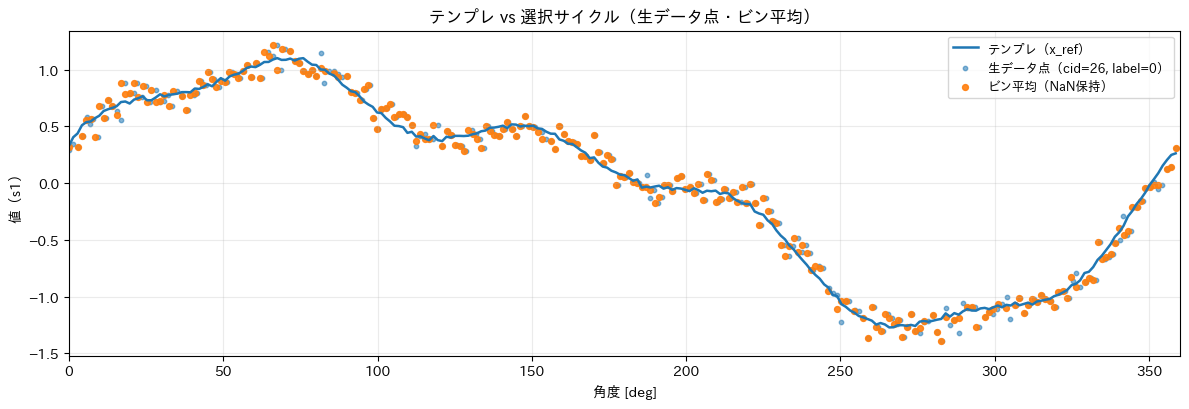

In [10]:

# ============================================================
# 3-7) 実行例（テンプレをランダム作成 → train/test特徴量 → MSPC行列）
# ============================================================


TEMPLATE_N = 50          # ←好きな数に変更
TEMPLATE_SEED = 0        # ←ランダム固定

# CWT（周波数スコア cwt_hl 用）の初期値
WAVELET  = "morl"   # 実数Morlet（安定・定番）
N_SCALES = 64       # まずは64（高低帯域に分けやすい())

# --- テンプレ作成：trainからランダムに任意本数（ラベル無視）---
x_ref, ref_mask, used_idx, used_cids = build_template_random_from_train(
    Xtr_nan,
    cids=cidtr,
    n_select=TEMPLATE_N,
    seed=TEMPLATE_SEED,
    min_bins=32
)

print("[template]")
print("template used cycles:", len(used_idx))
if used_cids is not None:
    print("example used cids:", used_cids[:10])


# ============================================================
# テンプレ作成に使ったサイクルから1本選び、raw点とビン平均を重ねて比較
# ============================================================
# 1) 比較するcycle_idを決める（used_cidsがあればそれを使う）
if used_cids is not None:
    cid_pick = int(np.asarray(used_cids, int)[0])  # 先頭の1本
else:
    # used_idx は「Xtr_nanの行index」なので、cidtrからcycle_idへ戻す
    cid_pick = int(np.asarray(cidtr, int)[int(np.asarray(used_idx, int)[0])])

# 2) 生データ点（不等間隔）
deg_raw, y_raw, lab = train_cycles[cid_pick]

# 3) ビン平均（NaN保持）を Xtr_nan から取り出す（cidtrで行を特定）
pos = int(np.where(np.asarray(cidtr, int) == cid_pick)[0][0])
x_bin = np.asarray(Xtr_nan[pos], float)
m_bin = np.asarray(Mtr[pos], int)
ok = (m_bin == 1) & np.isfinite(x_bin)

# 4) 1枚に重ねて表示
plt.figure(figsize=(12, 4.2))
plt.plot(deg_grid, x_ref, linewidth=1.8, label="テンプレ（x_ref）")
plt.scatter(deg_raw, y_raw, s=10, alpha=0.55, label=f"生データ点（cid={cid_pick}, label={lab}）")
plt.scatter(deg_grid[ok], x_bin[ok], s=18, alpha=0.9, label="ビン平均（NaN保持）")
plt.xlim(0, 360)
plt.xlabel("角度 [deg]")
plt.ylabel("値（s1）")
plt.title("テンプレ vs 選択サイクル（生データ点・ビン平均）")
plt.grid(True, alpha=0.25)
plt.legend(loc="best", fontsize=9)
plt.tight_layout()
plt.show()


In [11]:

# --- CWT設定 ---
# sampling_period は「サンプル間隔」なので deg_step を渡す（L_GRIDが等間隔の前提）
deg_step = 360.0 / float(L_GRID)

# --- 特徴量テーブル作成 ---
train_feat = build_feature_table(
    Xtr_nan, Mtr, ytr, cidtr, rel_tr,
    x_ref, ref_mask,
    wavelet=WAVELET, n_scales=N_SCALES, deg_step=deg_step,
    spike_k=6.0, phase_min_overlap=32, phase_signed=True
)

test_feat = build_feature_table(
    Xte_nan, Mte, yte, cidte, rel_te,
    x_ref, ref_mask,
    wavelet=WAVELET, n_scales=N_SCALES, deg_step=deg_step,
    spike_k=6.0, phase_min_overlap=32, phase_signed=True
)

print("[features ready]")
print("train rows:", len(train_feat["cycle_id"]), "test rows:", len(test_feat["cycle_id"]))


[features ready]
train rows: 700 test rows: 1020


In [12]:

# --- MSPC入力行列（列順は固定しておく） ---
MSPC_COLS = ["offset_abs","phase_shift_deg","phase_corr_max","cwt_hl","shape_rms","spike_max","spike_count"]
X_mspc_train = np.column_stack([train_feat[c] for c in MSPC_COLS])
X_mspc_test  = np.column_stack([test_feat[c]  for c in MSPC_COLS])

print("X_mspc_train:", X_mspc_train.shape)
print("X_mspc_test :", X_mspc_test.shape)

X_mspc_train: (700, 7)
X_mspc_test : (1020, 7)


# MSPCの実行

In [13]:

# ============================================================
# 4) MSPC(PCA): 学習（train）→ スコア算出（train/test）→ 可視化 → 評価
#   - ラベルで背景色分け
#   - PCA 寄与率（explained variance ratio）
#   - 負荷量（loadings）
#   - 正解率など（2値: 正常=0 / 異常=それ以外）
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# ===== 設定（ここだけ変えればOK）=====
VAR_RATIO = 0.95   # PCAの累積寄与率（0.90〜0.99 で調整）
ALPHA     = 0.995  # 閾値（正常trainの分位点）
N_LOAD_PLOT = 3    # 負荷量を表示する主成分数（例: 3）


# ===== 1) DataFrame化 =====
df_tr = pd.DataFrame({k: np.asarray(v) for k, v in train_feat.items()})
df_te = pd.DataFrame({k: np.asarray(v) for k, v in test_feat.items()})

# MSPC入力列（既に上で定義済み MSPC_COLS を使う）
feat_cols = list(MSPC_COLS)

# 欠損があれば train平均で埋める（特徴量計算が失敗した場合の保険）
for c in feat_cols:
    mu = pd.to_numeric(df_tr[c], errors="coerce").astype(float).mean()
    df_tr[c] = pd.to_numeric(df_tr[c], errors="coerce").astype(float).fillna(mu)
    df_te[c] = pd.to_numeric(df_te[c], errors="coerce").astype(float).fillna(mu)

# 2値の正解ラベル（正常=0, 異常=1）
y_tr = (df_tr["label"].astype(int).to_numpy() != 0).astype(int)
y_te = (df_te["label"].astype(int).to_numpy() != 0).astype(int)

# 学習に使う「正常train」だけを抽出（MSPCの基本）
is_tr_normal = (df_tr["label"].astype(int).to_numpy() == 0)

Xtr = df_tr[feat_cols].to_numpy(float)
Xte = df_te[feat_cols].to_numpy(float)

Xtr_n = Xtr[is_tr_normal]
print("Xtr(all):", Xtr.shape, "Xtr(normal):", Xtr_n.shape, "Xte:", Xte.shape)


Xtr(all): (700, 7) Xtr(normal): (700, 7) Xte: (1020, 7)


In [14]:


# ===== 2) 標準化（train正常で fit） =====
scaler = StandardScaler()
Xtr_n_s = scaler.fit_transform(Xtr_n)
Xtr_s   = scaler.transform(Xtr)   # 参考：train全体スコアも見たい時用
Xte_s   = scaler.transform(Xte)


# ===== 3) PCA 学習（train正常）=====
# n_components を VAR_RATIO で自動決定
pca_full = PCA().fit(Xtr_n_s)
cum = np.cumsum(pca_full.explained_variance_ratio_)
A = int(np.searchsorted(cum, VAR_RATIO) + 1)  # 必要な主成分数
A = max(1, min(A, len(feat_cols)))
print("selected n_components A =", A, "  (cum_var=", float(cum[A-1]), ")")

pca = PCA(n_components=A)
pca.fit(Xtr_n_s)

# 主成分（負荷量）と固有値
P = pca.components_                 # (A, p)
lam = pca.explained_variance_       # (A,)
lam = np.maximum(lam, 1e-12)   # 0割り防止（分散0の主成分が混ざるケース）


selected n_components A = 5   (cum_var= 0.9863755073496481 )


In [15]:


# ===== 4) MSPCスコア（T2 と Q）=====
def mspc_scores(Xs, P, lam):
    """
    Xs: 標準化済み (N,p)
    P : PCA成分 (A,p)
    lam: PCA固有値 (A,)
    return: T2 (N,), Q (N,), score1 (N,)
    """
    # スコア（主成分座標）
    T = Xs @ P.T                     # (N,A)
    # Hotelling T^2
    T2 = np.sum((T**2) / lam[None, :], axis=1)   # (N,)
    # 再構成（主成分で戻す）
    Xhat = T @ P                     # (N,p)
    R = Xs - Xhat                    # 残差
    Q = np.sum(R**2, axis=1)         # SPE（Squared Prediction Error）
    return T2, Q

T2_tr_n, Q_tr_n = mspc_scores(Xtr_n_s, P, lam)   # 閾値用（正常train）
T2_tr,   Q_tr   = mspc_scores(Xtr_s,   P, lam)   # 参考（train全体）
T2_te,   Q_te   = mspc_scores(Xte_s,   P, lam)

thr_T2 = float(np.quantile(T2_tr_n, ALPHA))
thr_Q  = float(np.quantile(Q_tr_n,  ALPHA))
thr_T2 = max(thr_T2, 1e-12)
thr_Q  = max(thr_Q,  1e-12)

# 1本スコア（見やすい用）：T2 と Q を「閾値で割って」最大を取る
score_tr = np.maximum(T2_tr / thr_T2, Q_tr / thr_Q)
score_te = np.maximum(T2_te / thr_T2, Q_te / thr_Q)
thr_score = 1.0

print("thr_T2=", thr_T2, "thr_Q=", thr_Q, "thr_score=", thr_score)



thr_T2= 35.107376101195115 thr_Q= 3.2891081834521616 thr_score= 1.0


In [16]:

# ===== 5) 可視化ヘルパ（ラベルで背景色分け）=====
def make_label_style(labels):
    labels = np.asarray(labels, int)
    u = np.unique(labels)
    # 色は matplotlib の C0,C1,... を順に割り当て（固定色指定はしない）
    # normal(0) だけ薄く見えるように最後に灰色寄りにしてもよいが、ここでは単純割当
    cmap = {}
    for i, lab in enumerate(u):
        cmap[int(lab)] = f"C{i%10}"
    return cmap

def shade_by_label(ax, labels, label_to_color, alpha=0.10):
    labels = np.asarray(labels, int)
    n = len(labels)
    if n == 0:
        return
    start = 0
    while start < n:
        lab = int(labels[start])
        end = start + 1
        while end < n and int(labels[end]) == lab:
            end += 1
        ax.axvspan(start - 0.5, end - 0.5, color=label_to_color.get(lab, "0.9"), alpha=alpha, lw=0)
        start = end

def add_label_legend(ax, label_to_color):
    handles = []
    for lab, col in sorted(label_to_color.items(), key=lambda x: x[0]):
        handles.append(Patch(facecolor=col, edgecolor="none", alpha=0.35, label=f"label={lab}"))
    ax.legend(handles=handles, loc="upper right", fontsize=8, framealpha=0.9)


label_to_color_tr = make_label_style(df_tr["label"].to_numpy())
label_to_color_te = make_label_style(df_te["label"].to_numpy())


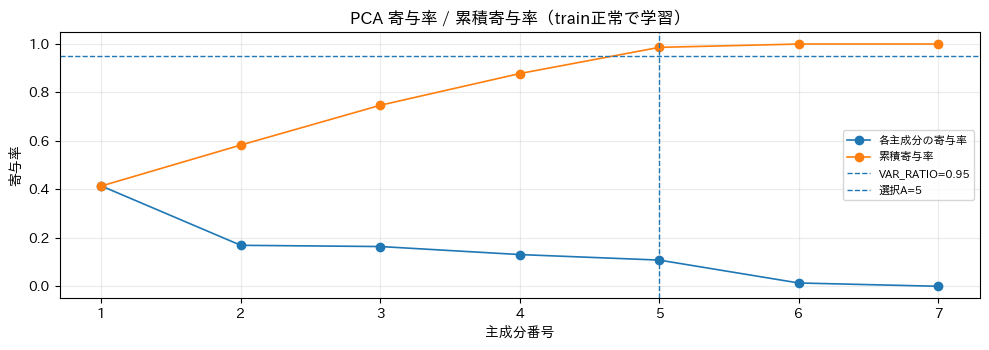

In [17]:

# ============================================================
# 4-1) PCA 寄与率（explained variance ratio）
# ============================================================

plt.figure(figsize=(10, 3.6))
x = np.arange(1, len(pca_full.explained_variance_ratio_) + 1)
plt.plot(x, pca_full.explained_variance_ratio_, marker="o", linewidth=1.2, label="各主成分の寄与率")
plt.plot(x, np.cumsum(pca_full.explained_variance_ratio_), marker="o", linewidth=1.2, label="累積寄与率")
plt.axhline(VAR_RATIO, linestyle="--", linewidth=1.0, label=f"VAR_RATIO={VAR_RATIO}")
plt.axvline(A, linestyle="--", linewidth=1.0, label=f"選択A={A}")
plt.xlabel("主成分番号")
plt.ylabel("寄与率")
plt.title("PCA 寄与率 / 累積寄与率（train正常で学習）")
plt.grid(True, alpha=0.25)
plt.legend(loc="best", fontsize=8)
plt.tight_layout()
plt.show()


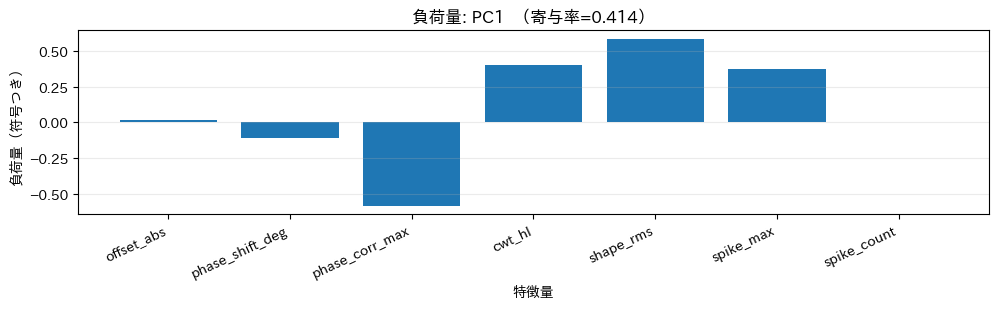

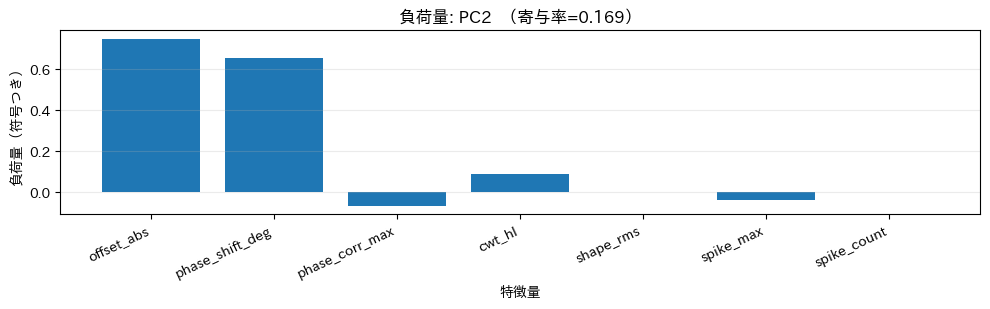

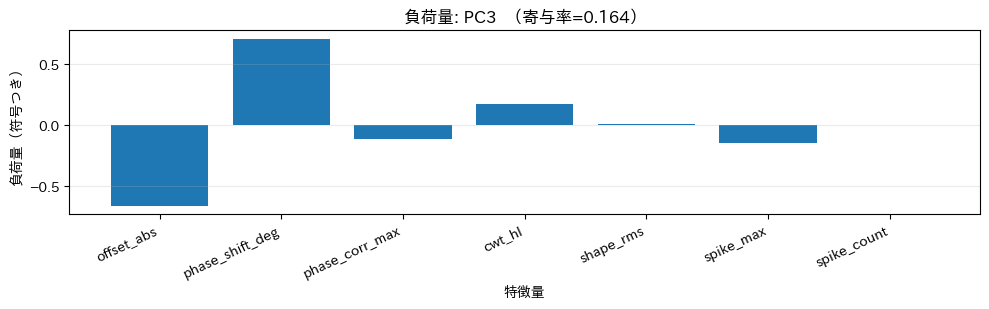

In [18]:

# ============================================================
# 4-2) PCA 負荷量（loadings）
#   - 「主成分がどの特徴量を強く見ているか」
#   - pca.components_ は (A, p) で、行=主成分、列=特徴量
# ============================================================

P_load = pca.components_  # (A, p)
p = len(feat_cols)
K = int(min(N_LOAD_PLOT, P_load.shape[0]))

for k in range(K):
    plt.figure(figsize=(10, 3.2))
    plt.bar(np.arange(p), P_load[k])
    plt.xticks(np.arange(p), feat_cols, rotation=25, ha="right")
    plt.xlabel("特徴量")
    plt.ylabel("負荷量（符号つき）")
    plt.title(f"負荷量: PC{k+1}  （寄与率={pca.explained_variance_ratio_[k]:.3f}）")
    plt.grid(True, axis="y", alpha=0.25)
    plt.tight_layout()
    plt.show()


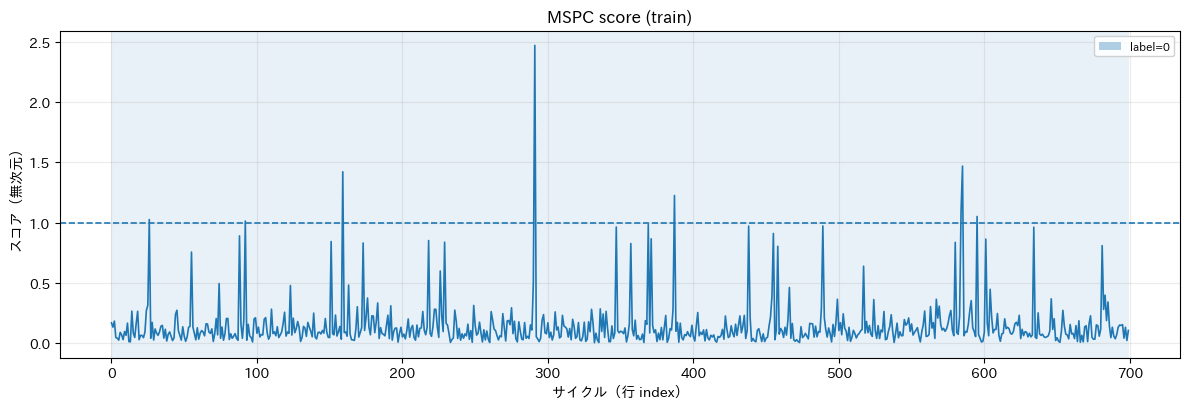

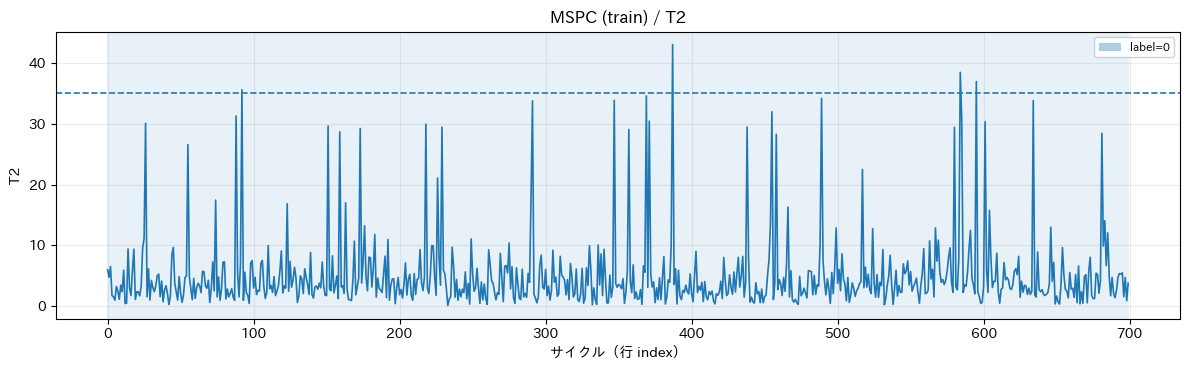

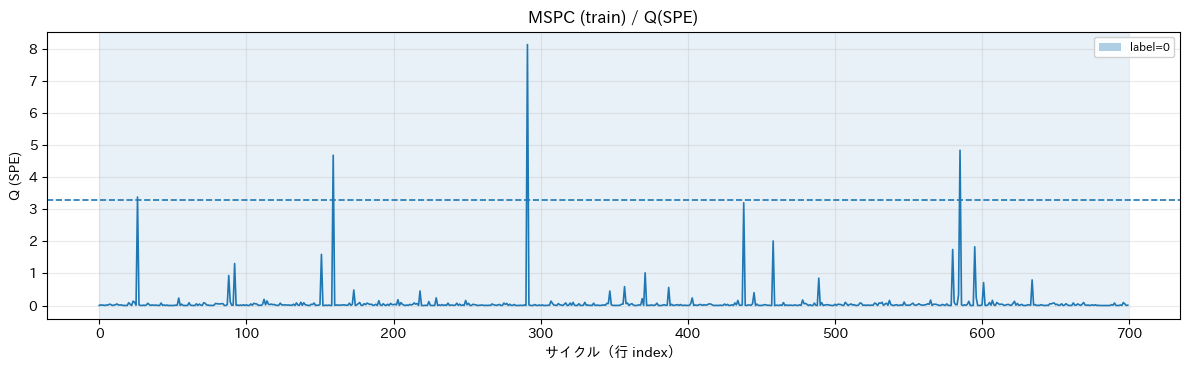

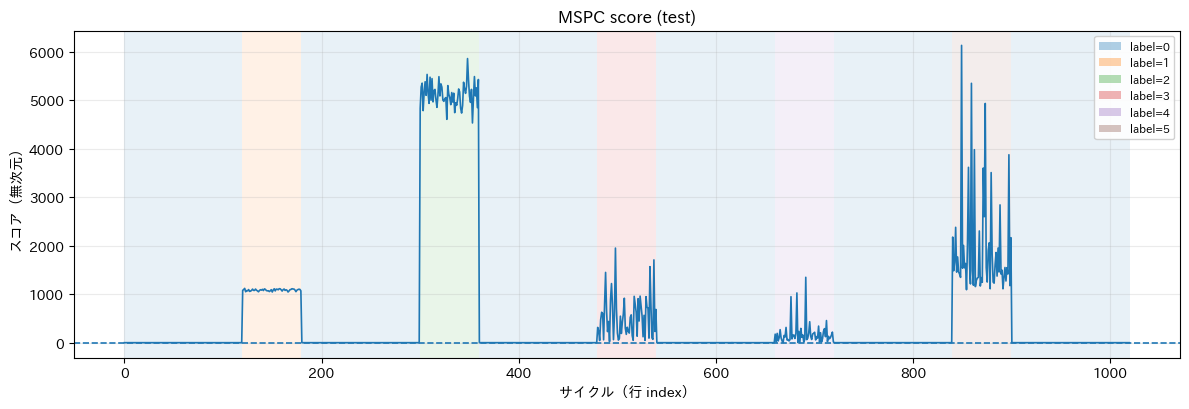

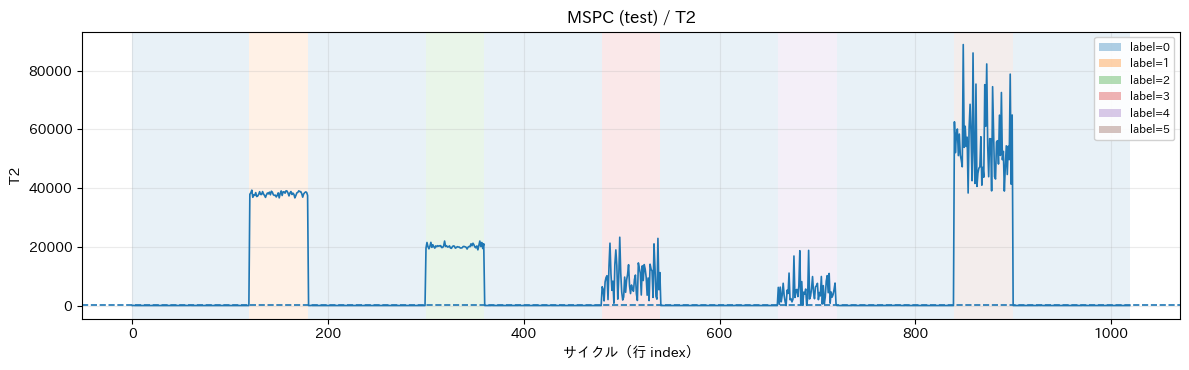

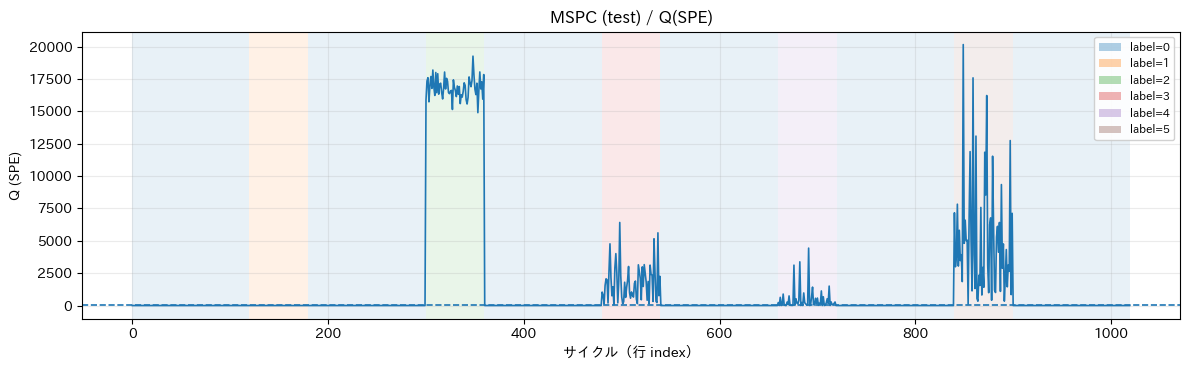

In [19]:

# ============================================================
# 4-3) スコア可視化（背景=ラベル）
#   - score = max(T2/thr_T2, Q/thr_Q) を表示（閾値=1）
#   - 参考として T2, Q も表示
# ============================================================

def plot_scores_with_bg(score, thr, labels, title, label_to_color):
    n = len(score)
    plt.figure(figsize=(12, 4.2))
    ax = plt.gca()
    shade_by_label(ax, labels, label_to_color, alpha=0.10)
    ax.plot(np.arange(n), score, linewidth=1.2, label="score = max(T2/thr_T2, Q/thr_Q)")
    ax.axhline(thr, linewidth=1.2, linestyle="--", label=f"thr={thr}")
    ax.set_xlabel("サイクル（行 index）")
    ax.set_ylabel("スコア（無次元）")
    ax.set_title(title)
    ax.grid(True, alpha=0.25)
    add_label_legend(ax, label_to_color)
    plt.tight_layout()
    plt.show()

def plot_T2Q_with_bg(T2, thr_T2, Q, thr_Q, labels, title, label_to_color):
    n = len(T2)

    plt.figure(figsize=(12, 3.8))
    ax = plt.gca()
    shade_by_label(ax, labels, label_to_color, alpha=0.10)
    ax.plot(np.arange(n), T2, linewidth=1.2, label="T2")
    ax.axhline(thr_T2, linewidth=1.2, linestyle="--", label=f"thr_T2={thr_T2:.3g}")
    ax.set_xlabel("サイクル（行 index）")
    ax.set_ylabel("T2")
    ax.set_title(title + " / T2")
    ax.grid(True, alpha=0.25)
    add_label_legend(ax, label_to_color)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 3.8))
    ax = plt.gca()
    shade_by_label(ax, labels, label_to_color, alpha=0.10)
    ax.plot(np.arange(n), Q, linewidth=1.2, label="Q")
    ax.axhline(thr_Q, linewidth=1.2, linestyle="--", label=f"thr_Q={thr_Q:.3g}")
    ax.set_xlabel("サイクル（行 index）")
    ax.set_ylabel("Q (SPE)")
    ax.set_title(title + " / Q(SPE)")
    ax.grid(True, alpha=0.25)
    add_label_legend(ax, label_to_color)
    plt.tight_layout()
    plt.show()


# --- train ---
plot_scores_with_bg(
    score_tr, thr_score,
    df_tr["label"].to_numpy(),
    title="MSPC score (train)",
    label_to_color=label_to_color_tr
)

plot_T2Q_with_bg(
    T2_tr, thr_T2, Q_tr, thr_Q,
    df_tr["label"].to_numpy(),
    title="MSPC (train)",
    label_to_color=label_to_color_tr
)

# --- test ---
plot_scores_with_bg(
    score_te, thr_score,
    df_te["label"].to_numpy(),
    title="MSPC score (test)",
    label_to_color=label_to_color_te
)

plot_T2Q_with_bg(
    T2_te, thr_T2, Q_te, thr_Q,
    df_te["label"].to_numpy(),
    title="MSPC (test)",
    label_to_color=label_to_color_te
)


In [20]:

# ============================================================
# 4-4) 評価（2値: 正常=0 / 異常=それ以外）
#   - 予測: score>1 または (T2>thr_T2) or (Q>thr_Q)
# ============================================================

def bin_metrics(y_true, y_pred):
    y_true = np.asarray(y_true, int)
    y_pred = np.asarray(y_pred, int)

    tp = int(np.sum((y_true==1) & (y_pred==1)))
    tn = int(np.sum((y_true==0) & (y_pred==0)))
    fp = int(np.sum((y_true==0) & (y_pred==1)))
    fn = int(np.sum((y_true==1) & (y_pred==0)))

    acc = (tp+tn) / max(1, (tp+tn+fp+fn))
    prec = tp / max(1, (tp+fp))
    rec  = tp / max(1, (tp+fn))
    f1 = (2*prec*rec) / max(1e-12, (prec+rec))
    return {"acc":acc, "prec":prec, "rec":rec, "f1":f1, "tp":tp, "tn":tn, "fp":fp, "fn":fn}

# 予測（どちらか）
pred_tr = ( (T2_tr > thr_T2) | (Q_tr > thr_Q) ).astype(int)
pred_te = ( (T2_te > thr_T2) | (Q_te > thr_Q) ).astype(int)

m_tr = bin_metrics(y_tr, pred_tr)
m_te = bin_metrics(y_te, pred_te)

print("[TRAIN (binary)]", m_tr, "  FPR_train=", m_tr["fp"]/max(1,(m_tr["fp"]+m_tr["tn"])))
print("[TEST  (binary)]", m_te, "  FPR_test =", m_te["fp"]/max(1,(m_te["fp"]+m_te["tn"])))

# 混同行列（見やすい表示）
cm = pd.DataFrame(
    [[m_te["tn"], m_te["fp"]],
     [m_te["fn"], m_te["tp"]]],
    index=["true_normal(0)","true_anom(1)"],
    columns=["pred_normal(0)","pred_anom(1)"]
)
cm


[TRAIN (binary)] {'acc': 0.9885714285714285, 'prec': 0.0, 'rec': 0.0, 'f1': 0.0, 'tp': 0, 'tn': 692, 'fp': 8, 'fn': 0}   FPR_train= 0.011428571428571429
[TEST  (binary)] {'acc': 0.9803921568627451, 'prec': 0.940251572327044, 'rec': 0.9966666666666667, 'f1': 0.9676375404530745, 'tp': 299, 'tn': 701, 'fp': 19, 'fn': 1}   FPR_test = 0.02638888888888889


,pred_normal(0),pred_anom(1)
true_normal(0),701,19
true_anom(1),1,299
